##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用内置方法进行训练和评估

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://tensorflow.google.cn/guide/keras/train_and_evaluate" class=""><img src="https://tensorflow.google.cn/images/tf_logo_32px.png" class="">在 TensorFlow.org 上查看</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/train_and_evaluate.ipynb" class=""><img src="https://tensorflow.google.cn/images/colab_logo_32px.png" class="">在 Google Colab 中运行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/guide/keras/train_and_evaluate.ipynb" class=""><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" class="">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/guide/keras/train_and_evaluate.ipynb" class=""><img src="https://tensorflow.google.cn/images/download_logo_32px.png" class="">下载笔记本</a></td>
</table>

## 设置

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## 简介

本指南涵盖使用内置 API 进行训练和验证时需要的训练、评估和预测（推断）模型（例如 `model.fit()`、`model.evaluate()`、`model.predict()`）。

如果您有兴趣在指定自己的训练步骤函数时利用 `fit()`，请参阅<a data-md-type="link" href="https://tensorflow.google.cn/guide/keras/customizing_what_happens_in_fit/" class="">“自定义 `fit()` 中发生的操作”</a>指南。

如果您有兴趣从头开始编写自己的训练和评估循环，请参阅[“从头开始编写训练循环”](https://tensorflow.google.cn/guide/keras/writing_a_training_loop_from_scratch/)指南。

一般而言，无论您使用内置循环还是编写自己的循环，模型训练和评估都会在每种 Keras 模型中严格按照相同的方式工作 -- 序贯模型、使用函数式 API 构建的模型以及通过模型子类化从头编写的模型。

本指南不涉及分布式训练。有关分布式训练，请参阅我们的[多 GPU 和分布式训练指南](/guides/distributed_training/)。

## API 概述：第一个端到端示例

将数据传递到模型的内置训练循环时，应当使用 **NumPy 数组**（如果数据很小且适合装入内存）或 **`tf.data Dataset` 对象**。在接下来的段落中，我们将 MNIST 数据集用作 NumPy 数组，以演示如何使用优化器、损失和指标。

我们考虑以下模型（在这里，我们使用函数式 API 构建了此模型，但它也可以是序贯模型或子类化模型）：

In [3]:
inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, activation="softmax", name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

下面是典型的端到端工作流，包括：

- 训练
- 根据从原始训练数据生成的预留集进行验证
- 根据测试数据进行评估

在此示例中，我们使用 MNIST 数据。

In [4]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

我们指定训练配置（优化器、损失、指标）：

In [5]:
model.compile(
    optimizer=keras.optimizers.RMSprop(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.SparseCategoricalCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

我们调用 `fit()`，它会通过将数据切成大小为“batch_size”的“批次”，然后将整个数据集重复迭代给定数量的“周期”来训练模型。

In [6]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=2,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
)

Fit model on training data


Epoch 1/2


  1/782 [..............................] - ETA: 0s - loss: 2.3858 - sparse_categorical_accuracy: 0.0938

 23/782 [..............................] - ETA: 1s - loss: 1.5555 - sparse_categorical_accuracy: 0.5795

 47/782 [>.............................] - ETA: 1s - loss: 1.1787 - sparse_categorical_accuracy: 0.6918

 71/782 [=>............................] - ETA: 1s - loss: 0.9763 - sparse_categorical_accuracy: 0.7434

 93/782 [==>...........................] - ETA: 1s - loss: 0.8535 - sparse_categorical_accuracy: 0.7740

117/782 [===>..........................] - ETA: 1s - loss: 0.7741 - sparse_categorical_accuracy: 0.7943

141/782 [====>.........................] - ETA: 1s - loss: 0.7157 - sparse_categorical_accuracy: 0.8093

164/782 [=====>........................] - ETA: 1s - loss: 0.6697 - sparse_categorical_accuracy: 0.8186

187/782 [======>.......................] - ETA: 1s - loss: 0.6339 - sparse_categorical_accuracy: 0.8270

211/782 [=======>......................] - ETA: 1s - loss: 0.6016 - sparse_categorical_accuracy: 0.8350

235/782 [========>.....................] - ETA: 1s - loss: 0.5738 - sparse_categorical_accuracy: 0.8414

259/782 [========>.....................] - ETA: 1s - loss: 0.5487 - sparse_categorical_accuracy: 0.8481

283/782 [=========>....................] - ETA: 1s - loss: 0.5258 - sparse_categorical_accuracy: 0.8536

307/782 [==========>...................] - ETA: 1s - loss: 0.5110 - sparse_categorical_accuracy: 0.8570

330/782 [===========>..................] - ETA: 0s - loss: 0.4973 - sparse_categorical_accuracy: 0.8601

355/782 [============>.................] - ETA: 0s - loss: 0.4807 - sparse_categorical_accuracy: 0.8649

379/782 [=============>................] - ETA: 0s - loss: 0.4704 - sparse_categorical_accuracy: 0.8677

403/782 [==============>...............] - ETA: 0s - loss: 0.4599 - sparse_categorical_accuracy: 0.8705

427/782 [===============>..............] - ETA: 0s - loss: 0.4489 - sparse_categorical_accuracy: 0.8732

451/782 [================>.............] - ETA: 0s - loss: 0.4383 - sparse_categorical_accuracy: 0.8762

475/782 [=================>............] - ETA: 0s - loss: 0.4275 - sparse_categorical_accuracy: 0.8790

498/782 [==================>...........] - ETA: 0s - loss: 0.4191 - sparse_categorical_accuracy: 0.8810

522/782 [===================>..........] - ETA: 0s - loss: 0.4106 - sparse_categorical_accuracy: 0.8831

546/782 [===================>..........] - ETA: 0s - loss: 0.4034 - sparse_categorical_accuracy: 0.8854

570/782 [====================>.........] - ETA: 0s - loss: 0.3960 - sparse_categorical_accuracy: 0.8873

594/782 [=====================>........] - ETA: 0s - loss: 0.3892 - sparse_categorical_accuracy: 0.8891

618/782 [======================>.......] - ETA: 0s - loss: 0.3841 - sparse_categorical_accuracy: 0.8904

642/782 [=======================>......] - ETA: 0s - loss: 0.3782 - sparse_categorical_accuracy: 0.8922

666/782 [========================>.....] - ETA: 0s - loss: 0.3728 - sparse_categorical_accuracy: 0.8937

690/782 [=========================>....] - ETA: 0s - loss: 0.3673 - sparse_categorical_accuracy: 0.8952

715/782 [==========================>...] - ETA: 0s - loss: 0.3621 - sparse_categorical_accuracy: 0.8967

739/782 [===========================>..] - ETA: 0s - loss: 0.3571 - sparse_categorical_accuracy: 0.8982

764/782 [============================>.] - ETA: 0s - loss: 0.3525 - sparse_categorical_accuracy: 0.8997

782/782 [==============================] - 2s 3ms/step - loss: 0.3494 - sparse_categorical_accuracy: 0.9003 - val_loss: 0.1909 - val_sparse_categorical_accuracy: 0.9463


Epoch 2/2
  1/782 [..............................] - ETA: 0s - loss: 0.1898 - sparse_categorical_accuracy: 0.9375

 25/782 [..............................] - ETA: 1s - loss: 0.1755 - sparse_categorical_accuracy: 0.9463

 50/782 [>.............................] - ETA: 1s - loss: 0.1916 - sparse_categorical_accuracy: 0.9416

 74/782 [=>............................] - ETA: 1s - loss: 0.1968 - sparse_categorical_accuracy: 0.9421

 97/782 [==>...........................] - ETA: 1s - loss: 0.2001 - sparse_categorical_accuracy: 0.9412

121/782 [===>..........................] - ETA: 1s - loss: 0.1928 - sparse_categorical_accuracy: 0.9440

144/782 [====>.........................] - ETA: 1s - loss: 0.1907 - sparse_categorical_accuracy: 0.9439

168/782 [=====>........................] - ETA: 1s - loss: 0.1874 - sparse_categorical_accuracy: 0.9443

192/782 [======>.......................] - ETA: 1s - loss: 0.1862 - sparse_categorical_accuracy: 0.9448

213/782 [=======>......................] - ETA: 1s - loss: 0.1853 - sparse_categorical_accuracy: 0.9452

235/782 [========>.....................] - ETA: 1s - loss: 0.1838 - sparse_categorical_accuracy: 0.9453

258/782 [========>.....................] - ETA: 1s - loss: 0.1811 - sparse_categorical_accuracy: 0.9463

281/782 [=========>....................] - ETA: 1s - loss: 0.1817 - sparse_categorical_accuracy: 0.9462

304/782 [==========>...................] - ETA: 1s - loss: 0.1808 - sparse_categorical_accuracy: 0.9464

326/782 [===========>..................] - ETA: 0s - loss: 0.1810 - sparse_categorical_accuracy: 0.9465

347/782 [============>.................] - ETA: 0s - loss: 0.1800 - sparse_categorical_accuracy: 0.9467

369/782 [=============>................] - ETA: 0s - loss: 0.1806 - sparse_categorical_accuracy: 0.9466

393/782 [==============>...............] - ETA: 0s - loss: 0.1785 - sparse_categorical_accuracy: 0.9473

417/782 [==============>...............] - ETA: 0s - loss: 0.1767 - sparse_categorical_accuracy: 0.9480

442/782 [===============>..............] - ETA: 0s - loss: 0.1746 - sparse_categorical_accuracy: 0.9487

465/782 [================>.............] - ETA: 0s - loss: 0.1738 - sparse_categorical_accuracy: 0.9492

489/782 [=================>............] - ETA: 0s - loss: 0.1742 - sparse_categorical_accuracy: 0.9489

513/782 [==================>...........] - ETA: 0s - loss: 0.1726 - sparse_categorical_accuracy: 0.9493

538/782 [===================>..........] - ETA: 0s - loss: 0.1719 - sparse_categorical_accuracy: 0.9496

562/782 [====================>.........] - ETA: 0s - loss: 0.1711 - sparse_categorical_accuracy: 0.9498

587/782 [=====================>........] - ETA: 0s - loss: 0.1701 - sparse_categorical_accuracy: 0.9500

612/782 [======================>.......] - ETA: 0s - loss: 0.1687 - sparse_categorical_accuracy: 0.9504

637/782 [=======================>......] - ETA: 0s - loss: 0.1688 - sparse_categorical_accuracy: 0.9504

662/782 [========================>.....] - ETA: 0s - loss: 0.1682 - sparse_categorical_accuracy: 0.9507

687/782 [=========================>....] - ETA: 0s - loss: 0.1674 - sparse_categorical_accuracy: 0.9510

712/782 [==========================>...] - ETA: 0s - loss: 0.1663 - sparse_categorical_accuracy: 0.9511

737/782 [===========================>..] - ETA: 0s - loss: 0.1652 - sparse_categorical_accuracy: 0.9516

761/782 [============================>.] - ETA: 0s - loss: 0.1641 - sparse_categorical_accuracy: 0.9517

782/782 [==============================] - 2s 2ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.1359 - val_sparse_categorical_accuracy: 0.9619


返回的“历史”对象保留训练期间的损失值和指标值记录：

In [7]:
history.history

{'loss': [0.3494057357311249, 0.16317875683307648],
 'sparse_categorical_accuracy': [0.9003000259399414, 0.9518399834632874],
 'val_loss': [0.19090703129768372, 0.13591724634170532],
 'val_sparse_categorical_accuracy': [0.9463000297546387, 0.961899995803833]}

我们通过 `evaluate()` 根据测试数据评估模型：

In [8]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
 1/79 [..............................] - ETA: 0s - loss: 0.0550 - sparse_categorical_accuracy: 0.9922

31/79 [==========>...................] - ETA: 0s - loss: 0.1782 - sparse_categorical_accuracy: 0.9446

61/79 [======================>.......] - ETA: 0s - loss: 0.1425 - sparse_categorical_accuracy: 0.9566

79/79 [==============================] - 0s 2ms/step - loss: 0.1338 - sparse_categorical_accuracy: 0.9593


test loss, test acc: [0.1338379979133606, 0.9592999815940857]
Generate predictions for 3 samples


predictions shape: (3, 10)


现在，我们来详细查看此工作流的每一部分。

## `compile()` 方法：指定损失、指标和优化器

要使用 `fit()` 训练模型，您需要指定损失函数、优化器以及一些要监视的指标（可选）。

将它们作为 `compile()` 方法的参数传递给模型：

In [9]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy()],
)

`metrics` 参数应当为列表 -- 您的模型可以具有任意数量的指标。

如果模型具有多个输出，则可以为每个输出指定不同的损失和指标，并且可以调节每个输出对模型总损失的贡献。您可以在**“将数据传递到多输入、多输出模型”**部分中找到有关此内容的更多详细信息。

请注意，如果您对默认设置感到满意，那么在许多情况下，都可以通过字符串标识符将优化器、损失和指标指定为捷径：

In [10]:
model.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)

为方便以后重用，我们将模型定义和编译步骤放入函数中；我们将在本指南的不同示例中多次调用它们。

In [11]:
def get_uncompiled_model():
    inputs = keras.Input(shape=(784,), name="digits")
    x = layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs = layers.Dense(10, activation="softmax", name="predictions")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


def get_compiled_model():
    model = get_uncompiled_model()
    model.compile(
        optimizer="rmsprop",
        loss="sparse_categorical_crossentropy",
        metrics=["sparse_categorical_accuracy"],
    )
    return model


### 提供许多内置优化器、损失和指标

通常，您不必从头开始创建自己的损失、指标或优化器，因为您需要的可能已经是 Keras API 的一部分：

优化器：

- `SGD()`（有或没有动量）
- `RMSprop()`
- `Adam()`
- 等等

损失：

- `MeanSquaredError()`
- `KLDivergence()`
- `CosineSimilarity()`
- 等等

指标：

- `AUC()`
- `Precision()`
- `Recall()`
- 等等

### 自定义损失

有两种方法来使用 Keras 提供自定义损失。第一个示例创建一个接受输入 `y_true` 和 `y_pred` 的函数。下面的示例显示了一个计算实际数据与预测值之间的均方误差的损失函数：

In [12]:
def custom_mean_squared_error(y_true, y_pred):
    return tf.math.reduce_mean(tf.square(y_true - y_pred))


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=custom_mean_squared_error)

# We need to one-hot encode the labels to use MSE
y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 0.0915

 33/782 [>.............................] - ETA: 1s - loss: 0.0726

 66/782 [=>............................] - ETA: 1s - loss: 0.0522

 99/782 [==>...........................] - ETA: 1s - loss: 0.0421

132/782 [====>.........................] - ETA: 1s - loss: 0.0361

164/782 [=====>........................] - ETA: 0s - loss: 0.0321

197/782 [======>.......................] - ETA: 0s - loss: 0.0292

229/782 [=======>......................] - ETA: 0s - loss: 0.0270

262/782 [=========>....................] - ETA: 0s - loss: 0.0253

294/782 [==========>...................] - ETA: 0s - loss: 0.0239

326/782 [===========>..................] - ETA: 0s - loss: 0.0227

358/782 [============>.................] - ETA: 0s - loss: 0.0218

390/782 [=============>................] - ETA: 0s - loss: 0.0209

422/782 [===============>..............] - ETA: 0s - loss: 0.0203

454/782 [================>.............] - ETA: 0s - loss: 0.0196

486/782 [=================>............] - ETA: 0s - loss: 0.0192

518/782 [==================>...........] - ETA: 0s - loss: 0.0186

549/782 [====================>.........] - ETA: 0s - loss: 0.0182

582/782 [=====================>........] - ETA: 0s - loss: 0.0178

614/782 [======================>.......] - ETA: 0s - loss: 0.0173

646/782 [=======================>......] - ETA: 0s - loss: 0.0170

678/782 [=========================>....] - ETA: 0s - loss: 0.0166

710/782 [==========================>...] - ETA: 0s - loss: 0.0164

742/782 [===========================>..] - ETA: 0s - loss: 0.0161

774/782 [============================>.] - ETA: 0s - loss: 0.0158

782/782 [==============================] - 1s 2ms/step - loss: 0.0157


如果您需要一个使用除 `y_true` 和 `y_pred` 之外的其他参数的损失函数，则可以将 `tf.keras.losses.Loss` 类子类化，并实现以下两个方法：

- `__init__(self)`：接受要在调用损失函数期间传递的参数
- `call(self, y_true, y_pred)`：使用目标 (y_true) 和模型预测 (y_pred) 来计算模型的损失

假设您要使用均方误差，但存在一个会抑制预测值远离 0.5（我们假设分类目标采用独热编码，且取值介于 0 和 1 之间）的附加项。这会为模型创建一个激励，使其不会对预测值过于自信，这可能有助于减轻过拟合（在尝试之前，我们不知道它是否有效！）。

您可以按以下方式处理：

In [13]:
class CustomMSE(keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="custom_mse"):
        super().__init__(name=name)
        self.regularization_factor = regularization_factor

    def call(self, y_true, y_pred):
        mse = tf.math.reduce_mean(tf.square(y_true - y_pred))
        reg = tf.math.reduce_mean(tf.square(0.5 - y_pred))
        return mse + reg * self.regularization_factor


model = get_uncompiled_model()
model.compile(optimizer=keras.optimizers.Adam(), loss=CustomMSE())

y_train_one_hot = tf.one_hot(y_train, depth=10)
model.fit(x_train, y_train_one_hot, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 0.1071

 30/782 [>.............................] - ETA: 1s - loss: 0.0917

 59/782 [=>............................] - ETA: 1s - loss: 0.0751

 88/782 [==>...........................] - ETA: 1s - loss: 0.0654

117/782 [===>..........................] - ETA: 1s - loss: 0.0597

146/782 [====>.........................] - ETA: 1s - loss: 0.0557

176/782 [=====>........................] - ETA: 1s - loss: 0.0529

206/782 [======>.......................] - ETA: 0s - loss: 0.0507

236/782 [========>.....................] - ETA: 0s - loss: 0.0489

266/782 [=========>....................] - ETA: 0s - loss: 0.0476

295/782 [==========>...................] - ETA: 0s - loss: 0.0464

324/782 [===========>..................] - ETA: 0s - loss: 0.0454

353/782 [============>.................] - ETA: 0s - loss: 0.0446

381/782 [=============>................] - ETA: 0s - loss: 0.0439

411/782 [==============>...............] - ETA: 0s - loss: 0.0432

440/782 [===============>..............] - ETA: 0s - loss: 0.0426

469/782 [================>.............] - ETA: 0s - loss: 0.0421

498/782 [==================>...........] - ETA: 0s - loss: 0.0418

527/782 [===================>..........] - ETA: 0s - loss: 0.0413

556/782 [====================>.........] - ETA: 0s - loss: 0.0409

585/782 [=====================>........] - ETA: 0s - loss: 0.0405

614/782 [======================>.......] - ETA: 0s - loss: 0.0403

644/782 [=======================>......] - ETA: 0s - loss: 0.0400

673/782 [========================>.....] - ETA: 0s - loss: 0.0397

702/782 [=========================>....] - ETA: 0s - loss: 0.0394

731/782 [===========================>..] - ETA: 0s - loss: 0.0392

760/782 [============================>.] - ETA: 0s - loss: 0.0390

782/782 [==============================] - 1s 2ms/step - loss: 0.0388


### 自定义指标

如果您需要不属于 API 的指标，则可以通过将 `tf.keras.metrics.Metric` 类子类化来轻松创建自定义指标。您将需要实现 4 个方法：

- `__init__(self)`，您将在其中为指标创建状态变量。
- `update_state(self, y_true, y_pred, sample_weight=None)`，使用目标 y_true 和模型预测 y_pred 更新状态变量。
- `result(self)`，使用状态变量来计算最终结果。
- `reset_states(self)`，用于重新初始化指标的状态。

状态更新和结果计算分开保存（分别保存在 `update_state()` 和 `result()` 中），因为在某些情况下，结果计算的开销可能会非常大，并且只能定期执行。

下面是一个展示如何实现 `CategoricalTruePositives` 指标的简单示例，该指标可以计算有多少样本被正确分类为属于给定类：

In [14]:
class CategoricalTruePositives(keras.metrics.Metric):
    def __init__(self, name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[CategoricalTruePositives()],
)
model.fit(x_train, y_train, batch_size=64, epochs=3)

Epoch 1/3


  1/782 [..............................] - ETA: 0s - loss: 2.3674 - categorical_true_positives: 1.0000

 24/782 [..............................] - ETA: 1s - loss: 1.5388 - categorical_true_positives: 846.0000

 48/782 [>.............................] - ETA: 1s - loss: 1.1503 - categorical_true_positives: 2084.0000

 71/782 [=>............................] - ETA: 1s - loss: 0.9700 - categorical_true_positives: 3322.0000

 94/782 [==>...........................] - ETA: 1s - loss: 0.8519 - categorical_true_positives: 4605.0000

118/782 [===>..........................] - ETA: 1s - loss: 0.7691 - categorical_true_positives: 5931.0000

141/782 [====>.........................] - ETA: 1s - loss: 0.7067 - categorical_true_positives: 7245.0000

165/782 [=====>........................] - ETA: 1s - loss: 0.6631 - categorical_true_positives: 8614.0000

189/782 [======>.......................] - ETA: 1s - loss: 0.6273 - categorical_true_positives: 9978.0000

213/782 [=======>......................] - ETA: 1s - loss: 0.5911 - categorical_true_positives: 11378.0000

236/782 [========>.....................] - ETA: 1s - loss: 0.5658 - categorical_true_positives: 12711.0000

259/782 [========>.....................] - ETA: 1s - loss: 0.5460 - categorical_true_positives: 14039.0000

283/782 [=========>....................] - ETA: 1s - loss: 0.5255 - categorical_true_positives: 15437.0000

306/782 [==========>...................] - ETA: 1s - loss: 0.5099 - categorical_true_positives: 16774.0000

329/782 [===========>..................] - ETA: 0s - loss: 0.4924 - categorical_true_positives: 18125.0000

352/782 [============>.................] - ETA: 0s - loss: 0.4806 - categorical_true_positives: 19467.0000

376/782 [=============>................] - ETA: 0s - loss: 0.4675 - categorical_true_positives: 20868.0000

399/782 [==============>...............] - ETA: 0s - loss: 0.4547 - categorical_true_positives: 22234.0000

423/782 [===============>..............] - ETA: 0s - loss: 0.4446 - categorical_true_positives: 23636.0000

447/782 [================>.............] - ETA: 0s - loss: 0.4343 - categorical_true_positives: 25053.0000

471/782 [=================>............] - ETA: 0s - loss: 0.4242 - categorical_true_positives: 26471.0000

494/782 [=================>............] - ETA: 0s - loss: 0.4172 - categorical_true_positives: 27830.0000

518/782 [==================>...........] - ETA: 0s - loss: 0.4084 - categorical_true_positives: 29250.0000

542/782 [===================>..........] - ETA: 0s - loss: 0.4021 - categorical_true_positives: 30667.0000

566/782 [====================>.........] - ETA: 0s - loss: 0.3957 - categorical_true_positives: 32102.0000

589/782 [=====================>........] - ETA: 0s - loss: 0.3898 - categorical_true_positives: 33467.0000

613/782 [======================>.......] - ETA: 0s - loss: 0.3848 - categorical_true_positives: 34892.0000

637/782 [=======================>......] - ETA: 0s - loss: 0.3805 - categorical_true_positives: 36307.0000

661/782 [========================>.....] - ETA: 0s - loss: 0.3757 - categorical_true_positives: 37721.0000

685/782 [=========================>....] - ETA: 0s - loss: 0.3688 - categorical_true_positives: 39171.0000

709/782 [==========================>...] - ETA: 0s - loss: 0.3632 - categorical_true_positives: 40612.0000

732/782 [===========================>..] - ETA: 0s - loss: 0.3589 - categorical_true_positives: 41983.0000

756/782 [============================>.] - ETA: 0s - loss: 0.3540 - categorical_true_positives: 43430.0000

779/782 [============================>.] - ETA: 0s - loss: 0.3506 - categorical_true_positives: 44797.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.3502 - categorical_true_positives: 44932.0000


Epoch 2/3
  1/782 [..............................] - ETA: 0s - loss: 0.1417 - categorical_true_positives: 61.0000

 25/782 [..............................] - ETA: 1s - loss: 0.1932 - categorical_true_positives: 1508.0000

 49/782 [>.............................] - ETA: 1s - loss: 0.1912 - categorical_true_positives: 2956.0000

 73/782 [=>............................] - ETA: 1s - loss: 0.1844 - categorical_true_positives: 4414.0000

 97/782 [==>...........................] - ETA: 1s - loss: 0.1889 - categorical_true_positives: 5862.0000

121/782 [===>..........................] - ETA: 1s - loss: 0.1863 - categorical_true_positives: 7310.0000

145/782 [====>.........................] - ETA: 1s - loss: 0.1875 - categorical_true_positives: 8762.0000

169/782 [=====>........................] - ETA: 1s - loss: 0.1849 - categorical_true_positives: 10216.0000

193/782 [======>.......................] - ETA: 1s - loss: 0.1887 - categorical_true_positives: 11657.0000

217/782 [=======>......................] - ETA: 1s - loss: 0.1900 - categorical_true_positives: 13102.0000

241/782 [========>.....................] - ETA: 1s - loss: 0.1867 - categorical_true_positives: 14570.0000

264/782 [=========>....................] - ETA: 1s - loss: 0.1846 - categorical_true_positives: 15969.0000

288/782 [==========>...................] - ETA: 1s - loss: 0.1831 - categorical_true_positives: 17426.0000

311/782 [==========>...................] - ETA: 1s - loss: 0.1809 - categorical_true_positives: 18837.0000

335/782 [===========>..................] - ETA: 0s - loss: 0.1807 - categorical_true_positives: 20290.0000

359/782 [============>.................] - ETA: 0s - loss: 0.1795 - categorical_true_positives: 21745.0000

383/782 [=============>................] - ETA: 0s - loss: 0.1791 - categorical_true_positives: 23207.0000

407/782 [==============>...............] - ETA: 0s - loss: 0.1792 - categorical_true_positives: 24668.0000

430/782 [===============>..............] - ETA: 0s - loss: 0.1788 - categorical_true_positives: 26077.0000

453/782 [================>.............] - ETA: 0s - loss: 0.1775 - categorical_true_positives: 27483.0000

477/782 [=================>............] - ETA: 0s - loss: 0.1771 - categorical_true_positives: 28934.0000

501/782 [==================>...........] - ETA: 0s - loss: 0.1761 - categorical_true_positives: 30397.0000

525/782 [===================>..........] - ETA: 0s - loss: 0.1761 - categorical_true_positives: 31849.0000

549/782 [====================>.........] - ETA: 0s - loss: 0.1754 - categorical_true_positives: 33308.0000

573/782 [====================>.........] - ETA: 0s - loss: 0.1745 - categorical_true_positives: 34778.0000

597/782 [=====================>........] - ETA: 0s - loss: 0.1736 - categorical_true_positives: 36240.0000

621/782 [======================>.......] - ETA: 0s - loss: 0.1732 - categorical_true_positives: 37706.0000

645/782 [=======================>......] - ETA: 0s - loss: 0.1732 - categorical_true_positives: 39156.0000

669/782 [========================>.....] - ETA: 0s - loss: 0.1732 - categorical_true_positives: 40626.0000

692/782 [=========================>....] - ETA: 0s - loss: 0.1721 - categorical_true_positives: 42035.0000

715/782 [==========================>...] - ETA: 0s - loss: 0.1713 - categorical_true_positives: 43445.0000

739/782 [===========================>..] - ETA: 0s - loss: 0.1707 - categorical_true_positives: 44909.0000

762/782 [============================>.] - ETA: 0s - loss: 0.1694 - categorical_true_positives: 46324.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1687 - categorical_true_positives: 47496.0000


Epoch 3/3
  1/782 [..............................] - ETA: 0s - loss: 0.1650 - categorical_true_positives: 61.0000

 25/782 [..............................] - ETA: 1s - loss: 0.1477 - categorical_true_positives: 1529.0000

 48/782 [>.............................] - ETA: 1s - loss: 0.1438 - categorical_true_positives: 2936.0000

 72/782 [=>............................] - ETA: 1s - loss: 0.1280 - categorical_true_positives: 4431.0000

 96/782 [==>...........................] - ETA: 1s - loss: 0.1317 - categorical_true_positives: 5908.0000

120/782 [===>..........................] - ETA: 1s - loss: 0.1284 - categorical_true_positives: 7387.0000

143/782 [====>.........................] - ETA: 1s - loss: 0.1274 - categorical_true_positives: 8805.0000

167/782 [=====>........................] - ETA: 1s - loss: 0.1277 - categorical_true_positives: 10272.0000

191/782 [======>.......................] - ETA: 1s - loss: 0.1303 - categorical_true_positives: 11740.0000

215/782 [=======>......................] - ETA: 1s - loss: 0.1298 - categorical_true_positives: 13229.0000

239/782 [========>.....................] - ETA: 1s - loss: 0.1292 - categorical_true_positives: 14713.0000

263/782 [=========>....................] - ETA: 1s - loss: 0.1281 - categorical_true_positives: 16197.0000

287/782 [==========>...................] - ETA: 1s - loss: 0.1278 - categorical_true_positives: 17672.0000

311/782 [==========>...................] - ETA: 1s - loss: 0.1272 - categorical_true_positives: 19146.0000

335/782 [===========>..................] - ETA: 0s - loss: 0.1249 - categorical_true_positives: 20634.0000

358/782 [============>.................] - ETA: 0s - loss: 0.1245 - categorical_true_positives: 22058.0000

381/782 [=============>................] - ETA: 0s - loss: 0.1240 - categorical_true_positives: 23473.0000

405/782 [==============>...............] - ETA: 0s - loss: 0.1259 - categorical_true_positives: 24941.0000

429/782 [===============>..............] - ETA: 0s - loss: 0.1241 - categorical_true_positives: 26431.0000

453/782 [================>.............] - ETA: 0s - loss: 0.1234 - categorical_true_positives: 27917.0000

477/782 [=================>............] - ETA: 0s - loss: 0.1243 - categorical_true_positives: 29384.0000

501/782 [==================>...........] - ETA: 0s - loss: 0.1239 - categorical_true_positives: 30858.0000

525/782 [===================>..........] - ETA: 0s - loss: 0.1235 - categorical_true_positives: 32343.0000

548/782 [====================>.........] - ETA: 0s - loss: 0.1229 - categorical_true_positives: 33763.0000

571/782 [====================>.........] - ETA: 0s - loss: 0.1229 - categorical_true_positives: 35183.0000

594/782 [=====================>........] - ETA: 0s - loss: 0.1218 - categorical_true_positives: 36615.0000

618/782 [======================>.......] - ETA: 0s - loss: 0.1226 - categorical_true_positives: 38093.0000

642/782 [=======================>......] - ETA: 0s - loss: 0.1246 - categorical_true_positives: 39563.0000

665/782 [========================>.....] - ETA: 0s - loss: 0.1243 - categorical_true_positives: 40986.0000

689/782 [=========================>....] - ETA: 0s - loss: 0.1244 - categorical_true_positives: 42463.0000

712/782 [==========================>...] - ETA: 0s - loss: 0.1239 - categorical_true_positives: 43876.0000

736/782 [===========================>..] - ETA: 0s - loss: 0.1241 - categorical_true_positives: 45353.0000

760/782 [============================>.] - ETA: 0s - loss: 0.1235 - categorical_true_positives: 46835.0000

782/782 [==============================] - 2s 2ms/step - loss: 0.1240 - categorical_true_positives: 48140.0000


### 处理不适合标准签名的损失和指标

可以根据 `y_true` 和 `y_pred` 计算出绝大多数损失和指标，其中 `y_pred` 是模型的输出。不过，仍有一些损失和指标无法计算，例如，正则化损失可能仅需要激活层（这种情况下没有目标），并且此激活可能不是模型输出。

在这种情况下，您可以从自定义层的调用方法内部调用 `self.add_loss(loss_value)`。以这种方式添加的损失会在训练期间添加到“主要”损失中（传递给 `compile()` 的损失）。下面是一个添加激活正则化的简单示例（请注意，激活正则化内置于所有 Keras 层中 -- 该层只是为了提供一个具体示例）：

In [15]:
class ActivityRegularizationLayer(layers.Layer):
    def call(self, inputs):
        self.add_loss(tf.reduce_sum(inputs) * 0.1)
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert activity regularization as a layer
x = ActivityRegularizationLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)

# The displayed loss will be much higher than before
# due to the regularization component.
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 70.1839

 27/782 [>.............................] - ETA: 1s - loss: 7.2850 

 54/782 [=>............................] - ETA: 1s - loss: 4.8450

 81/782 [==>...........................] - ETA: 1s - loss: 4.0066

108/782 [===>..........................] - ETA: 1s - loss: 3.5827

136/782 [====>.........................] - ETA: 1s - loss: 3.3202

163/782 [=====>........................] - ETA: 1s - loss: 3.1519

190/782 [======>.......................] - ETA: 1s - loss: 3.0315

217/782 [=======>......................] - ETA: 1s - loss: 2.9411

244/782 [========>.....................] - ETA: 1s - loss: 2.8707

271/782 [=========>....................] - ETA: 0s - loss: 2.8141

298/782 [==========>...................] - ETA: 0s - loss: 2.7679

325/782 [===========>..................] - ETA: 0s - loss: 2.7293

352/782 [============>.................] - ETA: 0s - loss: 2.6965

378/782 [=============>................] - ETA: 0s - loss: 2.6693

405/782 [==============>...............] - ETA: 0s - loss: 2.6449

432/782 [===============>..............] - ETA: 0s - loss: 2.6235

459/782 [================>.............] - ETA: 0s - loss: 2.6046

485/782 [=================>............] - ETA: 0s - loss: 2.5885

512/782 [==================>...........] - ETA: 0s - loss: 2.5734

539/782 [===================>..........] - ETA: 0s - loss: 2.5598

566/782 [====================>.........] - ETA: 0s - loss: 2.5475

593/782 [=====================>........] - ETA: 0s - loss: 2.5363

620/782 [======================>.......] - ETA: 0s - loss: 2.5261

647/782 [=======================>......] - ETA: 0s - loss: 2.5168

674/782 [========================>.....] - ETA: 0s - loss: 2.5081

701/782 [=========================>....] - ETA: 0s - loss: 2.5002

728/782 [==========================>...] - ETA: 0s - loss: 2.4928

755/782 [===========================>..] - ETA: 0s - loss: 2.4858

782/782 [==============================] - ETA: 0s - loss: 2.4796

782/782 [==============================] - 1s 2ms/step - loss: 2.4796


您可以使用 `add_metric()` 对记录指标值执行相同的操作：

In [16]:
class MetricLoggingLayer(layers.Layer):
    def call(self, inputs):
        # The `aggregation` argument defines
        # how to aggregate the per-batch values
        # over each epoch:
        # in this case we simply average them.
        self.add_metric(
            keras.backend.std(inputs), name="std_of_activation", aggregation="mean"
        )
        return inputs  # Pass-through layer.


inputs = keras.Input(shape=(784,), name="digits")
x = layers.Dense(64, activation="relu", name="dense_1")(inputs)

# Insert std logging as a layer.
x = MetricLoggingLayer()(x)

x = layers.Dense(64, activation="relu", name="dense_2")(x)
outputs = layers.Dense(10, name="predictions")(x)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 2.4018 - std_of_activation: 0.2347

 25/782 [..............................] - ETA: 1s - loss: 1.5653 - std_of_activation: 0.4545

 49/782 [>.............................] - ETA: 1s - loss: 1.1677 - std_of_activation: 0.5875

 74/782 [=>............................] - ETA: 1s - loss: 0.9578 - std_of_activation: 0.6712

 99/782 [==>...........................] - ETA: 1s - loss: 0.8258 - std_of_activation: 0.7322

124/782 [===>..........................] - ETA: 1s - loss: 0.7457 - std_of_activation: 0.7758

149/782 [====>.........................] - ETA: 1s - loss: 0.6897 - std_of_activation: 0.8051

174/782 [=====>........................] - ETA: 1s - loss: 0.6397 - std_of_activation: 0.8320

198/782 [======>.......................] - ETA: 1s - loss: 0.6014 - std_of_activation: 0.8532

223/782 [=======>......................] - ETA: 1s - loss: 0.5721 - std_of_activation: 0.8710

248/782 [========>.....................] - ETA: 1s - loss: 0.5464 - std_of_activation: 0.8862

273/782 [=========>....................] - ETA: 1s - loss: 0.5239 - std_of_activation: 0.8994

298/782 [==========>...................] - ETA: 1s - loss: 0.5046 - std_of_activation: 0.9107

323/782 [===========>..................] - ETA: 0s - loss: 0.4881 - std_of_activation: 0.9206

348/782 [============>.................] - ETA: 0s - loss: 0.4749 - std_of_activation: 0.9298

373/782 [=============>................] - ETA: 0s - loss: 0.4623 - std_of_activation: 0.9369

398/782 [==============>...............] - ETA: 0s - loss: 0.4518 - std_of_activation: 0.9433

423/782 [===============>..............] - ETA: 0s - loss: 0.4396 - std_of_activation: 0.9494

447/782 [================>.............] - ETA: 0s - loss: 0.4292 - std_of_activation: 0.9548

471/782 [=================>............] - ETA: 0s - loss: 0.4206 - std_of_activation: 0.9602

496/782 [==================>...........] - ETA: 0s - loss: 0.4133 - std_of_activation: 0.9645

521/782 [==================>...........] - ETA: 0s - loss: 0.4052 - std_of_activation: 0.9683

546/782 [===================>..........] - ETA: 0s - loss: 0.3981 - std_of_activation: 0.9723

571/782 [====================>.........] - ETA: 0s - loss: 0.3901 - std_of_activation: 0.9767

596/782 [=====================>........] - ETA: 0s - loss: 0.3828 - std_of_activation: 0.9802

621/782 [======================>.......] - ETA: 0s - loss: 0.3767 - std_of_activation: 0.9836

646/782 [=======================>......] - ETA: 0s - loss: 0.3708 - std_of_activation: 0.9868

671/782 [========================>.....] - ETA: 0s - loss: 0.3638 - std_of_activation: 0.9897

696/782 [=========================>....] - ETA: 0s - loss: 0.3576 - std_of_activation: 0.9926

721/782 [==========================>...] - ETA: 0s - loss: 0.3532 - std_of_activation: 0.9954

746/782 [===========================>..] - ETA: 0s - loss: 0.3487 - std_of_activation: 0.9981

771/782 [============================>.] - ETA: 0s - loss: 0.3437 - std_of_activation: 1.0007

782/782 [==============================] - 2s 2ms/step - loss: 0.3423 - std_of_activation: 1.0018


在[函数式 API](https://tensorflow.google.cn/guide/keras/functional/) 中，您还可以调用 `model.add_loss(loss_tensor)` 或 `model.add_metric(metric_tensor, name, aggregation)`。

下面是一个简单的示例：

In [17]:
inputs = keras.Input(shape=(784,), name="digits")
x1 = layers.Dense(64, activation="relu", name="dense_1")(inputs)
x2 = layers.Dense(64, activation="relu", name="dense_2")(x1)
outputs = layers.Dense(10, name="predictions")(x2)
model = keras.Model(inputs=inputs, outputs=outputs)

model.add_loss(tf.reduce_sum(x1) * 0.1)

model.add_metric(keras.backend.std(x1), name="std_of_activation", aggregation="mean")

model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 74.2056 - std_of_activation: 0.2609

 24/782 [..............................] - ETA: 1s - loss: 8.4137 - std_of_activation: 0.0446 

 48/782 [>.............................] - ETA: 1s - loss: 5.4296 - std_of_activation: 0.0257

 72/782 [=>............................] - ETA: 1s - loss: 4.3971 - std_of_activation: 0.0179

 97/782 [==>...........................] - ETA: 1s - loss: 3.8605 - std_of_activation: 0.0137

121/782 [===>..........................] - ETA: 1s - loss: 3.5529 - std_of_activation: 0.0112

145/782 [====>.........................] - ETA: 1s - loss: 3.3468 - std_of_activation: 0.0094

169/782 [=====>........................] - ETA: 1s - loss: 3.1991 - std_of_activation: 0.0082

193/782 [======>.......................] - ETA: 1s - loss: 3.0878 - std_of_activation: 0.0072

217/782 [=======>......................] - ETA: 1s - loss: 3.0007 - std_of_activation: 0.0065

241/782 [========>.....................] - ETA: 1s - loss: 2.9310 - std_of_activation: 0.0059

266/782 [=========>....................] - ETA: 1s - loss: 2.8719 - std_of_activation: 0.0053

291/782 [==========>...................] - ETA: 1s - loss: 2.8232 - std_of_activation: 0.0049

315/782 [===========>..................] - ETA: 0s - loss: 2.7834 - std_of_activation: 0.0045

339/782 [============>.................] - ETA: 0s - loss: 2.7493 - std_of_activation: 0.0042

363/782 [============>.................] - ETA: 0s - loss: 2.7198 - std_of_activation: 0.0039

387/782 [=============>................] - ETA: 0s - loss: 2.6939 - std_of_activation: 0.0037

411/782 [==============>...............] - ETA: 0s - loss: 2.6710 - std_of_activation: 0.0035

435/782 [===============>..............] - ETA: 0s - loss: 2.6508 - std_of_activation: 0.0033

459/782 [================>.............] - ETA: 0s - loss: 2.6325 - std_of_activation: 0.0032

483/782 [=================>............] - ETA: 0s - loss: 2.6161 - std_of_activation: 0.0030

507/782 [==================>...........] - ETA: 0s - loss: 2.6013 - std_of_activation: 0.0029

531/782 [===================>..........] - ETA: 0s - loss: 2.5878 - std_of_activation: 0.0027

555/782 [====================>.........] - ETA: 0s - loss: 2.5754 - std_of_activation: 0.0026

579/782 [=====================>........] - ETA: 0s - loss: 2.5641 - std_of_activation: 0.0025

603/782 [======================>.......] - ETA: 0s - loss: 2.5536 - std_of_activation: 0.0024

627/782 [=======================>......] - ETA: 0s - loss: 2.5440 - std_of_activation: 0.0023

651/782 [=======================>......] - ETA: 0s - loss: 2.5351 - std_of_activation: 0.0023

675/782 [========================>.....] - ETA: 0s - loss: 2.5269 - std_of_activation: 0.0022

699/782 [=========================>....] - ETA: 0s - loss: 2.5192 - std_of_activation: 0.0021

723/782 [==========================>...] - ETA: 0s - loss: 2.5120 - std_of_activation: 0.0020

747/782 [===========================>..] - ETA: 0s - loss: 2.5052 - std_of_activation: 0.0020

772/782 [============================>.] - ETA: 0s - loss: 2.4987 - std_of_activation: 0.0019

782/782 [==============================] - 2s 2ms/step - loss: 2.4963 - std_of_activation: 0.0019


请注意，当您通过 `add_loss()` 传递损失时，可以在没有损失函数的情况下调用 `compile()`，因为模型已经有损失要最小化。

考虑以下 `LogisticEndpoint` 层：它以目标和 logits 作为输入，并通过 `add_loss()` 跟踪交叉熵损失。另外，它还通过 `add_metric()` 跟踪分类准确率。

In [18]:
class LogisticEndpoint(keras.layers.Layer):
    def __init__(self, name=None):
        super(LogisticEndpoint, self).__init__(name=name)
        self.loss_fn = keras.losses.BinaryCrossentropy(from_logits=True)
        self.accuracy_fn = keras.metrics.BinaryAccuracy()

    def call(self, targets, logits, sample_weights=None):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        loss = self.loss_fn(targets, logits, sample_weights)
        self.add_loss(loss)

        # Log accuracy as a metric and add it
        # to the layer using `self.add_metric()`.
        acc = self.accuracy_fn(targets, logits, sample_weights)
        self.add_metric(acc, name="accuracy")

        # Return the inference-time prediction tensor (for `.predict()`).
        return tf.nn.softmax(logits)


您可以在具有两个输入（输入数据和目标）的模型中使用它，编译时无需 `loss` 参数，如下所示：

In [19]:
import numpy as np

inputs = keras.Input(shape=(3,), name="inputs")
targets = keras.Input(shape=(10,), name="targets")
logits = keras.layers.Dense(10)(inputs)
predictions = LogisticEndpoint(name="predictions")(logits, targets)

model = keras.Model(inputs=[inputs, targets], outputs=predictions)
model.compile(optimizer="adam")  # No loss argument!

data = {
    "inputs": np.random.random((3, 3)),
    "targets": np.random.random((3, 10)),
}
model.fit(data)

1/1 [==============================] - ETA: 0s - loss: 0.9475 - binary_accuracy: 0.0000e+00

1/1 [==============================] - 0s 2ms/step - loss: 0.9475 - binary_accuracy: 0.0000e+00


有关训练多输入模型的更多信息，请参阅**将数据传递到多输入、多输出模型**部分。

### 自动分离验证预留集

在您看到的第一个端到端示例中，我们使用了 `validation_data` 参数将 NumPy 数组 `(x_val, y_val)` 的元组传递给模型，用于在每个周期结束时评估验证损失和验证指标。

这是另一个选项：参数 `validation_split` 允许您自动保留部分训练数据以供验证。参数值表示要保留用于验证的数据比例，因此应将其设置为大于 0 且小于 1 的数字。例如，`validation_split=0.2` 表示“使用 20% 的数据进行验证”，而 `validation_split=0.6` 表示“使用 60% 的数据进行验证”。

验证的计算方式为：在任何乱序之前，抽取通过 fit 调用接收的数组最后 x% 的样本。

请注意，仅在使用 NumPy 数据进行训练时才能使用 `validation_split`。

In [20]:
model = get_compiled_model()
model.fit(x_train, y_train, batch_size=64, validation_split=0.2, epochs=1)

  1/625 [..............................] - ETA: 0s - loss: 2.3419 - sparse_categorical_accuracy: 0.1250

 28/625 [>.............................] - ETA: 1s - loss: 1.4612 - sparse_categorical_accuracy: 0.6233

 55/625 [=>............................] - ETA: 1s - loss: 1.1007 - sparse_categorical_accuracy: 0.7207

 83/625 [==>...........................] - ETA: 1s - loss: 0.9139 - sparse_categorical_accuracy: 0.7658

110/625 [====>.........................] - ETA: 0s - loss: 0.8023 - sparse_categorical_accuracy: 0.7911

138/625 [=====>........................] - ETA: 0s - loss: 0.7265 - sparse_categorical_accuracy: 0.8091

165/625 [======>.......................] - ETA: 0s - loss: 0.6640 - sparse_categorical_accuracy: 0.8242

192/625 [========>.....................] - ETA: 0s - loss: 0.6230 - sparse_categorical_accuracy: 0.8337

219/625 [=========>....................] - ETA: 0s - loss: 0.5822 - sparse_categorical_accuracy: 0.8438

246/625 [==========>...................] - ETA: 0s - loss: 0.5520 - sparse_categorical_accuracy: 0.8507

273/625 [============>.................] - ETA: 0s - loss: 0.5298 - sparse_categorical_accuracy: 0.8562

301/625 [=============>................] - ETA: 0s - loss: 0.5097 - sparse_categorical_accuracy: 0.8613

328/625 [==============>...............] - ETA: 0s - loss: 0.4922 - sparse_categorical_accuracy: 0.8657

355/625 [================>.............] - ETA: 0s - loss: 0.4776 - sparse_categorical_accuracy: 0.8691

383/625 [=================>............] - ETA: 0s - loss: 0.4621 - sparse_categorical_accuracy: 0.8734

410/625 [==================>...........] - ETA: 0s - loss: 0.4477 - sparse_categorical_accuracy: 0.8772

437/625 [===================>..........] - ETA: 0s - loss: 0.4361 - sparse_categorical_accuracy: 0.8800

464/625 [=====================>........] - ETA: 0s - loss: 0.4253 - sparse_categorical_accuracy: 0.8825

490/625 [======================>.......] - ETA: 0s - loss: 0.4179 - sparse_categorical_accuracy: 0.8845

517/625 [=======================>......] - ETA: 0s - loss: 0.4092 - sparse_categorical_accuracy: 0.8868

544/625 [=========================>....] - ETA: 0s - loss: 0.3990 - sparse_categorical_accuracy: 0.8898

571/625 [==========================>...] - ETA: 0s - loss: 0.3906 - sparse_categorical_accuracy: 0.8915

599/625 [===========================>..] - ETA: 0s - loss: 0.3831 - sparse_categorical_accuracy: 0.8935

625/625 [==============================] - 2s 2ms/step - loss: 0.3753 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.2478 - val_sparse_categorical_accuracy: 0.9242


## 通过 tf.data 数据集进行训练和评估

在前面的几个段落中，您已经了解如何处理损失、指标和优化器，并且已经知道在将数据作为 NumPy 数组传递时如何在 fit 中使用 `validation_data` 和 `validation_split` 参数。

现在，让我们看一下数据以 `tf.data.Dataset` 对象形式出现的情况。

`tf.data` API是 TensorFlow 2.0 中的一组实用工具，用于以快速且可扩展的方式加载和预处理数据。

有关创建 `Datasets` 的完整指南，请参阅 [tf.data 文档](https://tensorflow.google.cn/guide/data)。

您可以将 `Dataset` 实例直接传递给 `fit()`、`evaluate()` 和 `predict()`：

In [21]:
model = get_compiled_model()

# First, let's create a training Dataset instance.
# For the sake of our example, we'll use the same MNIST data as before.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Now we get a test dataset.
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(64)

# Since the dataset already takes care of batching,
# we don't pass a `batch_size` argument.
model.fit(train_dataset, epochs=3)

# You can also evaluate or predict on a dataset.
print("Evaluate")
result = model.evaluate(test_dataset)
dict(zip(model.metrics_names, result))

Epoch 1/3


  1/782 [..............................] - ETA: 0s - loss: 2.3319 - sparse_categorical_accuracy: 0.1250

 22/782 [..............................] - ETA: 1s - loss: 1.5331 - sparse_categorical_accuracy: 0.5717

 44/782 [>.............................] - ETA: 1s - loss: 1.1508 - sparse_categorical_accuracy: 0.6893

 66/782 [=>............................] - ETA: 1s - loss: 0.9402 - sparse_categorical_accuracy: 0.7467

 88/782 [==>...........................] - ETA: 1s - loss: 0.8060 - sparse_categorical_accuracy: 0.7820

110/782 [===>..........................] - ETA: 1s - loss: 0.7276 - sparse_categorical_accuracy: 0.8023

132/782 [====>.........................] - ETA: 1s - loss: 0.6753 - sparse_categorical_accuracy: 0.8146

155/782 [====>.........................] - ETA: 1s - loss: 0.6325 - sparse_categorical_accuracy: 0.8261

177/782 [=====>........................] - ETA: 1s - loss: 0.5936 - sparse_categorical_accuracy: 0.8362

199/782 [======>.......................] - ETA: 1s - loss: 0.5702 - sparse_categorical_accuracy: 0.8425

221/782 [=======>......................] - ETA: 1s - loss: 0.5527 - sparse_categorical_accuracy: 0.8466

244/782 [========>.....................] - ETA: 1s - loss: 0.5323 - sparse_categorical_accuracy: 0.8511

267/782 [=========>....................] - ETA: 1s - loss: 0.5147 - sparse_categorical_accuracy: 0.8556

290/782 [==========>...................] - ETA: 1s - loss: 0.4950 - sparse_categorical_accuracy: 0.8612

313/782 [===========>..................] - ETA: 1s - loss: 0.4785 - sparse_categorical_accuracy: 0.8659

336/782 [===========>..................] - ETA: 1s - loss: 0.4639 - sparse_categorical_accuracy: 0.8695

359/782 [============>.................] - ETA: 0s - loss: 0.4532 - sparse_categorical_accuracy: 0.8726

382/782 [=============>................] - ETA: 0s - loss: 0.4426 - sparse_categorical_accuracy: 0.8755

404/782 [==============>...............] - ETA: 0s - loss: 0.4312 - sparse_categorical_accuracy: 0.8784

427/782 [===============>..............] - ETA: 0s - loss: 0.4229 - sparse_categorical_accuracy: 0.8808

450/782 [================>.............] - ETA: 0s - loss: 0.4136 - sparse_categorical_accuracy: 0.8834

473/782 [=================>............] - ETA: 0s - loss: 0.4077 - sparse_categorical_accuracy: 0.8842

496/782 [==================>...........] - ETA: 0s - loss: 0.4036 - sparse_categorical_accuracy: 0.8852

519/782 [==================>...........] - ETA: 0s - loss: 0.3952 - sparse_categorical_accuracy: 0.8875

541/782 [===================>..........] - ETA: 0s - loss: 0.3892 - sparse_categorical_accuracy: 0.8892

564/782 [====================>.........] - ETA: 0s - loss: 0.3811 - sparse_categorical_accuracy: 0.8916

587/782 [=====================>........] - ETA: 0s - loss: 0.3767 - sparse_categorical_accuracy: 0.8930

609/782 [======================>.......] - ETA: 0s - loss: 0.3714 - sparse_categorical_accuracy: 0.8945

631/782 [=======================>......] - ETA: 0s - loss: 0.3667 - sparse_categorical_accuracy: 0.8955

653/782 [========================>.....] - ETA: 0s - loss: 0.3621 - sparse_categorical_accuracy: 0.8967

676/782 [========================>.....] - ETA: 0s - loss: 0.3577 - sparse_categorical_accuracy: 0.8977

698/782 [=========================>....] - ETA: 0s - loss: 0.3527 - sparse_categorical_accuracy: 0.8988

721/782 [==========================>...] - ETA: 0s - loss: 0.3483 - sparse_categorical_accuracy: 0.8999

744/782 [===========================>..] - ETA: 0s - loss: 0.3448 - sparse_categorical_accuracy: 0.9007

767/782 [============================>.] - ETA: 0s - loss: 0.3414 - sparse_categorical_accuracy: 0.9016

782/782 [==============================] - 2s 2ms/step - loss: 0.3396 - sparse_categorical_accuracy: 0.9021


Epoch 2/3
  1/782 [..............................] - ETA: 0s - loss: 0.2249 - sparse_categorical_accuracy: 0.9375

 23/782 [..............................] - ETA: 1s - loss: 0.2094 - sparse_categorical_accuracy: 0.9375

 45/782 [>.............................] - ETA: 1s - loss: 0.1966 - sparse_categorical_accuracy: 0.9434

 66/782 [=>............................] - ETA: 1s - loss: 0.1795 - sparse_categorical_accuracy: 0.9479

 88/782 [==>...........................] - ETA: 1s - loss: 0.1810 - sparse_categorical_accuracy: 0.9469

110/782 [===>..........................] - ETA: 1s - loss: 0.1795 - sparse_categorical_accuracy: 0.9487

133/782 [====>.........................] - ETA: 1s - loss: 0.1843 - sparse_categorical_accuracy: 0.9467

156/782 [====>.........................] - ETA: 1s - loss: 0.1826 - sparse_categorical_accuracy: 0.9455

178/782 [=====>........................] - ETA: 1s - loss: 0.1793 - sparse_categorical_accuracy: 0.9473

200/782 [======>.......................] - ETA: 1s - loss: 0.1787 - sparse_categorical_accuracy: 0.9477

222/782 [=======>......................] - ETA: 1s - loss: 0.1796 - sparse_categorical_accuracy: 0.9474

244/782 [========>.....................] - ETA: 1s - loss: 0.1781 - sparse_categorical_accuracy: 0.9476

267/782 [=========>....................] - ETA: 1s - loss: 0.1791 - sparse_categorical_accuracy: 0.9476

290/782 [==========>...................] - ETA: 1s - loss: 0.1750 - sparse_categorical_accuracy: 0.9488

313/782 [===========>..................] - ETA: 1s - loss: 0.1759 - sparse_categorical_accuracy: 0.9485

335/782 [===========>..................] - ETA: 1s - loss: 0.1744 - sparse_categorical_accuracy: 0.9487

357/782 [============>.................] - ETA: 0s - loss: 0.1742 - sparse_categorical_accuracy: 0.9486

380/782 [=============>................] - ETA: 0s - loss: 0.1730 - sparse_categorical_accuracy: 0.9489

403/782 [==============>...............] - ETA: 0s - loss: 0.1714 - sparse_categorical_accuracy: 0.9493

426/782 [===============>..............] - ETA: 0s - loss: 0.1704 - sparse_categorical_accuracy: 0.9495

448/782 [================>.............] - ETA: 0s - loss: 0.1702 - sparse_categorical_accuracy: 0.9492

471/782 [=================>............] - ETA: 0s - loss: 0.1684 - sparse_categorical_accuracy: 0.9493

494/782 [=================>............] - ETA: 0s - loss: 0.1699 - sparse_categorical_accuracy: 0.9491

516/782 [==================>...........] - ETA: 0s - loss: 0.1693 - sparse_categorical_accuracy: 0.9493

538/782 [===================>..........] - ETA: 0s - loss: 0.1681 - sparse_categorical_accuracy: 0.9497

561/782 [====================>.........] - ETA: 0s - loss: 0.1669 - sparse_categorical_accuracy: 0.9501

584/782 [=====================>........] - ETA: 0s - loss: 0.1671 - sparse_categorical_accuracy: 0.9501

607/782 [======================>.......] - ETA: 0s - loss: 0.1663 - sparse_categorical_accuracy: 0.9505

631/782 [=======================>......] - ETA: 0s - loss: 0.1653 - sparse_categorical_accuracy: 0.9506

654/782 [========================>.....] - ETA: 0s - loss: 0.1645 - sparse_categorical_accuracy: 0.9509

676/782 [========================>.....] - ETA: 0s - loss: 0.1640 - sparse_categorical_accuracy: 0.9510

699/782 [=========================>....] - ETA: 0s - loss: 0.1634 - sparse_categorical_accuracy: 0.9512

721/782 [==========================>...] - ETA: 0s - loss: 0.1633 - sparse_categorical_accuracy: 0.9511

743/782 [===========================>..] - ETA: 0s - loss: 0.1634 - sparse_categorical_accuracy: 0.9511

765/782 [============================>.] - ETA: 0s - loss: 0.1631 - sparse_categorical_accuracy: 0.9512

782/782 [==============================] - 2s 2ms/step - loss: 0.1632 - sparse_categorical_accuracy: 0.9512


Epoch 3/3
  1/782 [..............................] - ETA: 0s - loss: 0.0737 - sparse_categorical_accuracy: 0.9688

 23/782 [..............................] - ETA: 1s - loss: 0.1551 - sparse_categorical_accuracy: 0.9572

 45/782 [>.............................] - ETA: 1s - loss: 0.1326 - sparse_categorical_accuracy: 0.9611

 67/782 [=>............................] - ETA: 1s - loss: 0.1207 - sparse_categorical_accuracy: 0.9636

 89/782 [==>...........................] - ETA: 1s - loss: 0.1215 - sparse_categorical_accuracy: 0.9640

112/782 [===>..........................] - ETA: 1s - loss: 0.1201 - sparse_categorical_accuracy: 0.9647

135/782 [====>.........................] - ETA: 1s - loss: 0.1234 - sparse_categorical_accuracy: 0.9635

158/782 [=====>........................] - ETA: 1s - loss: 0.1239 - sparse_categorical_accuracy: 0.9627

180/782 [=====>........................] - ETA: 1s - loss: 0.1238 - sparse_categorical_accuracy: 0.9624

202/782 [======>.......................] - ETA: 1s - loss: 0.1215 - sparse_categorical_accuracy: 0.9634

224/782 [=======>......................] - ETA: 1s - loss: 0.1227 - sparse_categorical_accuracy: 0.9632

247/782 [========>.....................] - ETA: 1s - loss: 0.1235 - sparse_categorical_accuracy: 0.9634

270/782 [=========>....................] - ETA: 1s - loss: 0.1232 - sparse_categorical_accuracy: 0.9635

293/782 [==========>...................] - ETA: 1s - loss: 0.1215 - sparse_categorical_accuracy: 0.9640

315/782 [===========>..................] - ETA: 1s - loss: 0.1226 - sparse_categorical_accuracy: 0.9634

338/782 [===========>..................] - ETA: 1s - loss: 0.1214 - sparse_categorical_accuracy: 0.9639

360/782 [============>.................] - ETA: 0s - loss: 0.1207 - sparse_categorical_accuracy: 0.9640

383/782 [=============>................] - ETA: 0s - loss: 0.1201 - sparse_categorical_accuracy: 0.9644

406/782 [==============>...............] - ETA: 0s - loss: 0.1206 - sparse_categorical_accuracy: 0.9643

429/782 [===============>..............] - ETA: 0s - loss: 0.1211 - sparse_categorical_accuracy: 0.9644

453/782 [================>.............] - ETA: 0s - loss: 0.1193 - sparse_categorical_accuracy: 0.9647

477/782 [=================>............] - ETA: 0s - loss: 0.1180 - sparse_categorical_accuracy: 0.9650

500/782 [==================>...........] - ETA: 0s - loss: 0.1192 - sparse_categorical_accuracy: 0.9644

523/782 [===================>..........] - ETA: 0s - loss: 0.1191 - sparse_categorical_accuracy: 0.9644

545/782 [===================>..........] - ETA: 0s - loss: 0.1195 - sparse_categorical_accuracy: 0.9642

567/782 [====================>.........] - ETA: 0s - loss: 0.1196 - sparse_categorical_accuracy: 0.9641

589/782 [=====================>........] - ETA: 0s - loss: 0.1207 - sparse_categorical_accuracy: 0.9638

611/782 [======================>.......] - ETA: 0s - loss: 0.1205 - sparse_categorical_accuracy: 0.9639

634/782 [=======================>......] - ETA: 0s - loss: 0.1194 - sparse_categorical_accuracy: 0.9642

657/782 [========================>.....] - ETA: 0s - loss: 0.1192 - sparse_categorical_accuracy: 0.9642

680/782 [=========================>....] - ETA: 0s - loss: 0.1187 - sparse_categorical_accuracy: 0.9642

702/782 [=========================>....] - ETA: 0s - loss: 0.1185 - sparse_categorical_accuracy: 0.9643

725/782 [==========================>...] - ETA: 0s - loss: 0.1187 - sparse_categorical_accuracy: 0.9644

747/782 [===========================>..] - ETA: 0s - loss: 0.1186 - sparse_categorical_accuracy: 0.9644

770/782 [============================>.] - ETA: 0s - loss: 0.1189 - sparse_categorical_accuracy: 0.9644

782/782 [==============================] - 2s 2ms/step - loss: 0.1192 - sparse_categorical_accuracy: 0.9642


Evaluate


  1/157 [..............................] - ETA: 0s - loss: 0.0810 - sparse_categorical_accuracy: 0.9844

 30/157 [====>.........................] - ETA: 0s - loss: 0.1399 - sparse_categorical_accuracy: 0.9578

 59/157 [==========>...................] - ETA: 0s - loss: 0.1389 - sparse_categorical_accuracy: 0.9592

 88/157 [===============>..............] - ETA: 0s - loss: 0.1315 - sparse_categorical_accuracy: 0.9604

118/157 [=====================>........] - ETA: 0s - loss: 0.1190 - sparse_categorical_accuracy: 0.9646

147/157 [===========================>..] - ETA: 0s - loss: 0.1044 - sparse_categorical_accuracy: 0.9685

157/157 [==============================] - 0s 2ms/step - loss: 0.1083 - sparse_categorical_accuracy: 0.9675


{'loss': 0.10834348201751709,
 'sparse_categorical_accuracy': 0.9674999713897705}

请注意，数据集会在每个周期结束时重置，因此可以在下一个周期重复使用。

如果您只想在来自此数据集的特定数量批次上进行训练，则可以传递 `steps_per_epoch` 参数，此参数可以指定在继续下一个周期之前，模型应使用此数据集运行多少训练步骤。

如果执行此操作，则不会在每个周期结束时重置数据集，而是会继续绘制接下来的批次。数据集最终将用尽数据（除非它是无限循环的数据集）。

In [22]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Only use the 100 batches per epoch (that's 64 * 100 samples)
model.fit(train_dataset, epochs=3, steps_per_epoch=100)

Epoch 1/3


  1/100 [..............................] - ETA: 0s - loss: 2.3207 - sparse_categorical_accuracy: 0.0000e+00

 23/100 [=====>........................] - ETA: 0s - loss: 1.5192 - sparse_categorical_accuracy: 0.5870    

 46/100 [============>.................] - ETA: 0s - loss: 1.1208 - sparse_categorical_accuracy: 0.7041

 68/100 [===================>..........] - ETA: 0s - loss: 0.9173 - sparse_categorical_accuracy: 0.7587

 90/100 [==========================>...] - ETA: 0s - loss: 0.7961 - sparse_categorical_accuracy: 0.7892

100/100 [==============================] - 0s 2ms/step - loss: 0.7532 - sparse_categorical_accuracy: 0.7991


Epoch 2/3
  1/100 [..............................] - ETA: 0s - loss: 0.4289 - sparse_categorical_accuracy: 0.8750

 23/100 [=====>........................] - ETA: 0s - loss: 0.4023 - sparse_categorical_accuracy: 0.8852

 45/100 [============>.................] - ETA: 0s - loss: 0.3997 - sparse_categorical_accuracy: 0.8858

 68/100 [===================>..........] - ETA: 0s - loss: 0.3708 - sparse_categorical_accuracy: 0.8927

 90/100 [==========================>...] - ETA: 0s - loss: 0.3620 - sparse_categorical_accuracy: 0.8972

100/100 [==============================] - 0s 2ms/step - loss: 0.3595 - sparse_categorical_accuracy: 0.8978


Epoch 3/3
  1/100 [..............................] - ETA: 0s - loss: 0.4394 - sparse_categorical_accuracy: 0.8594

 23/100 [=====>........................] - ETA: 0s - loss: 0.3965 - sparse_categorical_accuracy: 0.8764

 46/100 [============>.................] - ETA: 0s - loss: 0.3528 - sparse_categorical_accuracy: 0.8947

 69/100 [===================>..........] - ETA: 0s - loss: 0.3338 - sparse_categorical_accuracy: 0.8997

 92/100 [==========================>...] - ETA: 0s - loss: 0.3177 - sparse_categorical_accuracy: 0.9051

100/100 [==============================] - 0s 2ms/step - loss: 0.3096 - sparse_categorical_accuracy: 0.9070


### 使用验证数据集

您可以在 `fit()` 中将 `Dataset` 实例作为 `validation_data` 参数传递：

In [23]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(train_dataset, epochs=1, validation_data=val_dataset)

  1/782 [..............................] - ETA: 0s - loss: 2.2898 - sparse_categorical_accuracy: 0.1406

 23/782 [..............................] - ETA: 1s - loss: 1.5149 - sparse_categorical_accuracy: 0.6128

 46/782 [>.............................] - ETA: 1s - loss: 1.1293 - sparse_categorical_accuracy: 0.7099

 68/782 [=>............................] - ETA: 1s - loss: 0.9387 - sparse_categorical_accuracy: 0.7585

 90/782 [==>...........................] - ETA: 1s - loss: 0.8167 - sparse_categorical_accuracy: 0.7870

112/782 [===>..........................] - ETA: 1s - loss: 0.7344 - sparse_categorical_accuracy: 0.8065

134/782 [====>.........................] - ETA: 1s - loss: 0.6809 - sparse_categorical_accuracy: 0.8198

157/782 [=====>........................] - ETA: 1s - loss: 0.6325 - sparse_categorical_accuracy: 0.8316

180/782 [=====>........................] - ETA: 1s - loss: 0.5943 - sparse_categorical_accuracy: 0.8392

203/782 [======>.......................] - ETA: 1s - loss: 0.5726 - sparse_categorical_accuracy: 0.8442

226/782 [=======>......................] - ETA: 1s - loss: 0.5529 - sparse_categorical_accuracy: 0.8481

249/782 [========>.....................] - ETA: 1s - loss: 0.5333 - sparse_categorical_accuracy: 0.8524

272/782 [=========>....................] - ETA: 1s - loss: 0.5154 - sparse_categorical_accuracy: 0.8560

295/782 [==========>...................] - ETA: 1s - loss: 0.4944 - sparse_categorical_accuracy: 0.8617

318/782 [===========>..................] - ETA: 1s - loss: 0.4775 - sparse_categorical_accuracy: 0.8656

341/782 [============>.................] - ETA: 0s - loss: 0.4639 - sparse_categorical_accuracy: 0.8695

364/782 [============>.................] - ETA: 0s - loss: 0.4516 - sparse_categorical_accuracy: 0.8733

387/782 [=============>................] - ETA: 0s - loss: 0.4409 - sparse_categorical_accuracy: 0.8758

410/782 [==============>...............] - ETA: 0s - loss: 0.4308 - sparse_categorical_accuracy: 0.8786

433/782 [===============>..............] - ETA: 0s - loss: 0.4214 - sparse_categorical_accuracy: 0.8809

456/782 [================>.............] - ETA: 0s - loss: 0.4128 - sparse_categorical_accuracy: 0.8834

479/782 [=================>............] - ETA: 0s - loss: 0.4073 - sparse_categorical_accuracy: 0.8849

502/782 [==================>...........] - ETA: 0s - loss: 0.3998 - sparse_categorical_accuracy: 0.8866

525/782 [===================>..........] - ETA: 0s - loss: 0.3922 - sparse_categorical_accuracy: 0.8886

547/782 [===================>..........] - ETA: 0s - loss: 0.3862 - sparse_categorical_accuracy: 0.8900

569/782 [====================>.........] - ETA: 0s - loss: 0.3785 - sparse_categorical_accuracy: 0.8921

591/782 [=====================>........] - ETA: 0s - loss: 0.3748 - sparse_categorical_accuracy: 0.8931

614/782 [======================>.......] - ETA: 0s - loss: 0.3689 - sparse_categorical_accuracy: 0.8948

637/782 [=======================>......] - ETA: 0s - loss: 0.3634 - sparse_categorical_accuracy: 0.8963

660/782 [========================>.....] - ETA: 0s - loss: 0.3593 - sparse_categorical_accuracy: 0.8974

683/782 [=========================>....] - ETA: 0s - loss: 0.3541 - sparse_categorical_accuracy: 0.8988

706/782 [==========================>...] - ETA: 0s - loss: 0.3504 - sparse_categorical_accuracy: 0.8995

728/782 [==========================>...] - ETA: 0s - loss: 0.3467 - sparse_categorical_accuracy: 0.9005

750/782 [===========================>..] - ETA: 0s - loss: 0.3425 - sparse_categorical_accuracy: 0.9015

773/782 [============================>.] - ETA: 0s - loss: 0.3393 - sparse_categorical_accuracy: 0.9022

782/782 [==============================] - 2s 3ms/step - loss: 0.3381 - sparse_categorical_accuracy: 0.9025 - val_loss: 0.1858 - val_sparse_categorical_accuracy: 0.9471


在每个周期结束时，模型将迭代验证数据集并计算验证损失和验证指标。

如果只想对此数据集中的特定数量批次运行验证，则可以传递 `validation_steps` 参数，此参数可以指定在中断验证并进入下一个周期之前，模型应使用验证数据集运行多少验证步骤：

In [24]:
model = get_compiled_model()

# Prepare the training dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

# Prepare the validation dataset
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(64)

model.fit(
    train_dataset,
    epochs=1,
    # Only run validation using the first 10 batches of the dataset
    # using the `validation_steps` argument
    validation_data=val_dataset,
    validation_steps=10,
)

  1/782 [..............................] - ETA: 0s - loss: 2.3923 - sparse_categorical_accuracy: 0.0938

 22/782 [..............................] - ETA: 1s - loss: 1.6257 - sparse_categorical_accuracy: 0.5746

 44/782 [>.............................] - ETA: 1s - loss: 1.2261 - sparse_categorical_accuracy: 0.6843

 66/782 [=>............................] - ETA: 1s - loss: 1.0187 - sparse_categorical_accuracy: 0.7396

 88/782 [==>...........................] - ETA: 1s - loss: 0.8797 - sparse_categorical_accuracy: 0.7729

110/782 [===>..........................] - ETA: 1s - loss: 0.7906 - sparse_categorical_accuracy: 0.7926

132/782 [====>.........................] - ETA: 1s - loss: 0.7320 - sparse_categorical_accuracy: 0.8075

154/782 [====>.........................] - ETA: 1s - loss: 0.6816 - sparse_categorical_accuracy: 0.8191

177/782 [=====>........................] - ETA: 1s - loss: 0.6359 - sparse_categorical_accuracy: 0.8316

200/782 [======>.......................] - ETA: 1s - loss: 0.6057 - sparse_categorical_accuracy: 0.8389

223/782 [=======>......................] - ETA: 1s - loss: 0.5857 - sparse_categorical_accuracy: 0.8424

247/782 [========>.....................] - ETA: 1s - loss: 0.5625 - sparse_categorical_accuracy: 0.8479

270/782 [=========>....................] - ETA: 1s - loss: 0.5417 - sparse_categorical_accuracy: 0.8531

294/782 [==========>...................] - ETA: 1s - loss: 0.5215 - sparse_categorical_accuracy: 0.8583

317/782 [===========>..................] - ETA: 1s - loss: 0.5039 - sparse_categorical_accuracy: 0.8631

340/782 [============>.................] - ETA: 0s - loss: 0.4895 - sparse_categorical_accuracy: 0.8667

363/782 [============>.................] - ETA: 0s - loss: 0.4747 - sparse_categorical_accuracy: 0.8703

386/782 [=============>................] - ETA: 0s - loss: 0.4624 - sparse_categorical_accuracy: 0.8733

410/782 [==============>...............] - ETA: 0s - loss: 0.4519 - sparse_categorical_accuracy: 0.8761

433/782 [===============>..............] - ETA: 0s - loss: 0.4395 - sparse_categorical_accuracy: 0.8793

455/782 [================>.............] - ETA: 0s - loss: 0.4310 - sparse_categorical_accuracy: 0.8813

478/782 [=================>............] - ETA: 0s - loss: 0.4233 - sparse_categorical_accuracy: 0.8829

501/782 [==================>...........] - ETA: 0s - loss: 0.4172 - sparse_categorical_accuracy: 0.8845

524/782 [===================>..........] - ETA: 0s - loss: 0.4073 - sparse_categorical_accuracy: 0.8869

547/782 [===================>..........] - ETA: 0s - loss: 0.3997 - sparse_categorical_accuracy: 0.8887

570/782 [====================>.........] - ETA: 0s - loss: 0.3932 - sparse_categorical_accuracy: 0.8905

593/782 [=====================>........] - ETA: 0s - loss: 0.3874 - sparse_categorical_accuracy: 0.8923

616/782 [======================>.......] - ETA: 0s - loss: 0.3807 - sparse_categorical_accuracy: 0.8940

639/782 [=======================>......] - ETA: 0s - loss: 0.3745 - sparse_categorical_accuracy: 0.8952

662/782 [========================>.....] - ETA: 0s - loss: 0.3696 - sparse_categorical_accuracy: 0.8964

685/782 [=========================>....] - ETA: 0s - loss: 0.3646 - sparse_categorical_accuracy: 0.8979

708/782 [==========================>...] - ETA: 0s - loss: 0.3598 - sparse_categorical_accuracy: 0.8989

731/782 [===========================>..] - ETA: 0s - loss: 0.3554 - sparse_categorical_accuracy: 0.9000

754/782 [===========================>..] - ETA: 0s - loss: 0.3503 - sparse_categorical_accuracy: 0.9011

778/782 [============================>.] - ETA: 0s - loss: 0.3470 - sparse_categorical_accuracy: 0.9020

782/782 [==============================] - 2s 2ms/step - loss: 0.3465 - sparse_categorical_accuracy: 0.9021 - val_loss: 0.3041 - val_sparse_categorical_accuracy: 0.9250


请注意，验证数据集将在每次使用后重置（这样您就可以在不同周期中始终根据相同的样本进行评估）。

通过 `Dataset` 对象进行训练时，不支持参数 `validation_split`（从训练数据生成预留集），因为此功能需要为数据集样本编制索引的能力，而 `Dataset` API 通常无法做到这一点。

## 支持的其他输入格式

除 NumPy 数组、Eager 张量和 TensorFlow `Datasets` 外，还可以使用 Pandas 数据帧或通过产生批量数据和标签的 Python 生成器训练 Keras 模型。

特别是，`keras.utils.Sequence` 类提供了一个简单的接口来构建可感知多处理并且可以打乱顺序的 Python 数据生成器。

通常，我们建议您使用：

- NumPy 输入数据，前提是您的数据很小且适合装入内存
- `Dataset` 对象，前提是您有大型数据集，且需要执行分布式训练
- `Sequence` 对象，前提是您具有大型数据集，且需要执行很多无法在 TensorFlow 中完成的自定义 Python 端处理（例如，如果您依赖外部库进行数据加载或预处理）。

## 使用 `keras.utils.Sequence` 对象作为输入

`keras.utils.Sequence` 是一个实用工具，您可以将其子类化以获得具有两个重要属性的 Python 生成器：

- 它适用于多处理。
- 可以打乱它的顺序（例如，在 `fit()` 中传递 `shuffle=True` 时）。

`Sequence` 必须实现两个方法：

- `__getitem__`
- `__len__`

`__getitem__` 方法应返回完整的批次。如果要在各个周期之间修改数据集，可以实现 `on_epoch_end`。

下面是一个简单的示例：

```python
from skimage.io import imread
from skimage.transform import resize
import numpy as np

# Here, `filenames` is list of path to the images
# and `labels` are the associated labels.

class CIFAR10Sequence(Sequence):
    def __init__(self, filenames, labels, batch_size):
        self.filenames, self.labels = filenames, labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.filenames[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        return np.array([
            resize(imread(filename), (200, 200))
               for filename in batch_x]), np.array(batch_y)

sequence = CIFAR10Sequence(filenames, labels, batch_size)
model.fit(sequence, epochs=10)
```

## 使用样本加权和类加权

在默认设置下，样本的权重由其在数据集中出现的频率决定。有两种方法可以独立于样本频率来加权数据：

- 类权重
- 样本权重

### 类权重

通过将字典传递给 `Model.fit()` 的 `class_weight` 参数来进行设置。此字典会将类索引映射到应当用于属于此类的样本的权重。

这可用于在不重采样的情况下平衡类，或者用于训练更加重视特定类的模型。

例如，在您的数据中，如果类“0”表示类“1”的一半，则可以使用 `Model.fit(..., class_weight={0: 1., 1: 0.5})`。

下面是一个 NumPy 示例，我们在其中使用类权重或样本权重来提高对类 #5（MNIST 数据集中的数字“5”）进行正确分类的重要性。

In [25]:
import numpy as np

class_weight = {
    0: 1.0,
    1: 1.0,
    2: 1.0,
    3: 1.0,
    4: 1.0,
    # Set weight "2" for class "5",
    # making this class 2x more important
    5: 2.0,
    6: 1.0,
    7: 1.0,
    8: 1.0,
    9: 1.0,
}

print("Fit with class weight")
model = get_compiled_model()
model.fit(x_train, y_train, class_weight=class_weight, batch_size=64, epochs=1)

Fit with class weight


  1/782 [..............................] - ETA: 0s - loss: 2.5094 - sparse_categorical_accuracy: 0.1250

 23/782 [..............................] - ETA: 1s - loss: 1.6802 - sparse_categorical_accuracy: 0.5605

 46/782 [>.............................] - ETA: 1s - loss: 1.2975 - sparse_categorical_accuracy: 0.6722

 69/782 [=>............................] - ETA: 1s - loss: 1.0734 - sparse_categorical_accuracy: 0.7278

 92/782 [==>...........................] - ETA: 1s - loss: 0.9557 - sparse_categorical_accuracy: 0.7571

115/782 [===>..........................] - ETA: 1s - loss: 0.8532 - sparse_categorical_accuracy: 0.7845

138/782 [====>.........................] - ETA: 1s - loss: 0.7812 - sparse_categorical_accuracy: 0.8024

161/782 [=====>........................] - ETA: 1s - loss: 0.7287 - sparse_categorical_accuracy: 0.8151

184/782 [======>.......................] - ETA: 1s - loss: 0.6822 - sparse_categorical_accuracy: 0.8263

207/782 [======>.......................] - ETA: 1s - loss: 0.6516 - sparse_categorical_accuracy: 0.8335

231/782 [=======>......................] - ETA: 1s - loss: 0.6207 - sparse_categorical_accuracy: 0.8415

254/782 [========>.....................] - ETA: 1s - loss: 0.5968 - sparse_categorical_accuracy: 0.8461

277/782 [=========>....................] - ETA: 1s - loss: 0.5730 - sparse_categorical_accuracy: 0.8523

300/782 [==========>...................] - ETA: 1s - loss: 0.5526 - sparse_categorical_accuracy: 0.8573

323/782 [===========>..................] - ETA: 1s - loss: 0.5404 - sparse_categorical_accuracy: 0.8606

346/782 [============>.................] - ETA: 0s - loss: 0.5272 - sparse_categorical_accuracy: 0.8634

369/782 [=============>................] - ETA: 0s - loss: 0.5121 - sparse_categorical_accuracy: 0.8672

392/782 [==============>...............] - ETA: 0s - loss: 0.5005 - sparse_categorical_accuracy: 0.8700

415/782 [==============>...............] - ETA: 0s - loss: 0.4902 - sparse_categorical_accuracy: 0.8723

438/782 [===============>..............] - ETA: 0s - loss: 0.4787 - sparse_categorical_accuracy: 0.8748

462/782 [================>.............] - ETA: 0s - loss: 0.4673 - sparse_categorical_accuracy: 0.8774

485/782 [=================>............] - ETA: 0s - loss: 0.4599 - sparse_categorical_accuracy: 0.8793

508/782 [==================>...........] - ETA: 0s - loss: 0.4504 - sparse_categorical_accuracy: 0.8818

531/782 [===================>..........] - ETA: 0s - loss: 0.4420 - sparse_categorical_accuracy: 0.8838

554/782 [====================>.........] - ETA: 0s - loss: 0.4334 - sparse_categorical_accuracy: 0.8858

577/782 [=====================>........] - ETA: 0s - loss: 0.4243 - sparse_categorical_accuracy: 0.8881

600/782 [======================>.......] - ETA: 0s - loss: 0.4171 - sparse_categorical_accuracy: 0.8897

623/782 [======================>.......] - ETA: 0s - loss: 0.4105 - sparse_categorical_accuracy: 0.8914

646/782 [=======================>......] - ETA: 0s - loss: 0.4048 - sparse_categorical_accuracy: 0.8927

669/782 [========================>.....] - ETA: 0s - loss: 0.3998 - sparse_categorical_accuracy: 0.8941

692/782 [=========================>....] - ETA: 0s - loss: 0.3927 - sparse_categorical_accuracy: 0.8959

716/782 [==========================>...] - ETA: 0s - loss: 0.3872 - sparse_categorical_accuracy: 0.8972

739/782 [===========================>..] - ETA: 0s - loss: 0.3825 - sparse_categorical_accuracy: 0.8985

762/782 [============================>.] - ETA: 0s - loss: 0.3777 - sparse_categorical_accuracy: 0.9000

782/782 [==============================] - 2s 2ms/step - loss: 0.3739 - sparse_categorical_accuracy: 0.9010


### 样本权重

对于细粒度控制，或者如果您不构建分类器，则可以使用“样本权重”。

- 通过 NumPy 数据进行训练时：将 `sample_weight` 参数传递给 `Model.fit()`。
- 通过 `tf.data` 或任何其他类型的迭代器进行训练时：产生 `(input_batch, label_batch, sample_weight_batch)` 元组。

“样本权重”数组是一个由数字组成的数组，这些数字用于指定批次中每个样本在计算总损失时应当具有的权重。它通常用于不平衡的分类问题（理念是将更多权重分配给罕见类）。

当使用的权重为 1 和 0 时，此数组可用作损失函数的*掩码*（完全丢弃某些样本对总损失的贡献）。

In [26]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

print("Fit with sample weight")
model = get_compiled_model()
model.fit(x_train, y_train, sample_weight=sample_weight, batch_size=64, epochs=1)

Fit with sample weight


  1/782 [..............................] - ETA: 0s - loss: 2.5626 - sparse_categorical_accuracy: 0.0000e+00

 24/782 [..............................] - ETA: 1s - loss: 1.7148 - sparse_categorical_accuracy: 0.5592    

 48/782 [>.............................] - ETA: 1s - loss: 1.3248 - sparse_categorical_accuracy: 0.6647

 71/782 [=>............................] - ETA: 1s - loss: 1.1053 - sparse_categorical_accuracy: 0.7214

 94/782 [==>...........................] - ETA: 1s - loss: 0.9627 - sparse_categorical_accuracy: 0.7585

118/782 [===>..........................] - ETA: 1s - loss: 0.8622 - sparse_categorical_accuracy: 0.7839

142/782 [====>.........................] - ETA: 1s - loss: 0.7930 - sparse_categorical_accuracy: 0.8006

165/782 [=====>........................] - ETA: 1s - loss: 0.7379 - sparse_categorical_accuracy: 0.8134

188/782 [======>.......................] - ETA: 1s - loss: 0.6964 - sparse_categorical_accuracy: 0.8228

211/782 [=======>......................] - ETA: 1s - loss: 0.6616 - sparse_categorical_accuracy: 0.8304

234/782 [=======>......................] - ETA: 1s - loss: 0.6276 - sparse_categorical_accuracy: 0.8390

257/782 [========>.....................] - ETA: 1s - loss: 0.6027 - sparse_categorical_accuracy: 0.8446

280/782 [=========>....................] - ETA: 1s - loss: 0.5812 - sparse_categorical_accuracy: 0.8498

304/782 [==========>...................] - ETA: 1s - loss: 0.5580 - sparse_categorical_accuracy: 0.8558

328/782 [===========>..................] - ETA: 0s - loss: 0.5418 - sparse_categorical_accuracy: 0.8603

352/782 [============>.................] - ETA: 0s - loss: 0.5240 - sparse_categorical_accuracy: 0.8647

375/782 [=============>................] - ETA: 0s - loss: 0.5094 - sparse_categorical_accuracy: 0.8684

399/782 [==============>...............] - ETA: 0s - loss: 0.4965 - sparse_categorical_accuracy: 0.8718

422/782 [===============>..............] - ETA: 0s - loss: 0.4852 - sparse_categorical_accuracy: 0.8743

445/782 [================>.............] - ETA: 0s - loss: 0.4748 - sparse_categorical_accuracy: 0.8770

469/782 [================>.............] - ETA: 0s - loss: 0.4653 - sparse_categorical_accuracy: 0.8795

493/782 [=================>............] - ETA: 0s - loss: 0.4570 - sparse_categorical_accuracy: 0.8815

516/782 [==================>...........] - ETA: 0s - loss: 0.4482 - sparse_categorical_accuracy: 0.8837

539/782 [===================>..........] - ETA: 0s - loss: 0.4405 - sparse_categorical_accuracy: 0.8856

563/782 [====================>.........] - ETA: 0s - loss: 0.4327 - sparse_categorical_accuracy: 0.8876

586/782 [=====================>........] - ETA: 0s - loss: 0.4246 - sparse_categorical_accuracy: 0.8898

610/782 [======================>.......] - ETA: 0s - loss: 0.4181 - sparse_categorical_accuracy: 0.8915

634/782 [=======================>......] - ETA: 0s - loss: 0.4113 - sparse_categorical_accuracy: 0.8929

657/782 [========================>.....] - ETA: 0s - loss: 0.4061 - sparse_categorical_accuracy: 0.8942

680/782 [=========================>....] - ETA: 0s - loss: 0.4006 - sparse_categorical_accuracy: 0.8955

704/782 [==========================>...] - ETA: 0s - loss: 0.3955 - sparse_categorical_accuracy: 0.8966

727/782 [==========================>...] - ETA: 0s - loss: 0.3894 - sparse_categorical_accuracy: 0.8978

750/782 [===========================>..] - ETA: 0s - loss: 0.3847 - sparse_categorical_accuracy: 0.8987

774/782 [============================>.] - ETA: 0s - loss: 0.3796 - sparse_categorical_accuracy: 0.8999

782/782 [==============================] - 2s 2ms/step - loss: 0.3782 - sparse_categorical_accuracy: 0.9003


下面是一个匹配的 `Dataset` 示例：

In [27]:
sample_weight = np.ones(shape=(len(y_train),))
sample_weight[y_train == 5] = 2.0

# Create a Dataset that includes sample weights
# (3rd element in the return tuple).
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train, sample_weight))

# Shuffle and slice the dataset.
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model = get_compiled_model()
model.fit(train_dataset, epochs=1)

  1/782 [..............................] - ETA: 0s - loss: 2.5210 - sparse_categorical_accuracy: 0.1250

 21/782 [..............................] - ETA: 1s - loss: 1.7259 - sparse_categorical_accuracy: 0.5610

 42/782 [>.............................] - ETA: 1s - loss: 1.3061 - sparse_categorical_accuracy: 0.6819

 63/782 [=>............................] - ETA: 1s - loss: 1.0701 - sparse_categorical_accuracy: 0.7398

 84/782 [==>...........................] - ETA: 1s - loss: 0.9375 - sparse_categorical_accuracy: 0.7723

105/782 [===>..........................] - ETA: 1s - loss: 0.8433 - sparse_categorical_accuracy: 0.7948

126/782 [===>..........................] - ETA: 1s - loss: 0.7791 - sparse_categorical_accuracy: 0.8108

147/782 [====>.........................] - ETA: 1s - loss: 0.7279 - sparse_categorical_accuracy: 0.8213

168/782 [=====>........................] - ETA: 1s - loss: 0.6794 - sparse_categorical_accuracy: 0.8330

189/782 [======>.......................] - ETA: 1s - loss: 0.6497 - sparse_categorical_accuracy: 0.8388

210/782 [=======>......................] - ETA: 1s - loss: 0.6217 - sparse_categorical_accuracy: 0.8443

231/782 [=======>......................] - ETA: 1s - loss: 0.6028 - sparse_categorical_accuracy: 0.8485

252/782 [========>.....................] - ETA: 1s - loss: 0.5842 - sparse_categorical_accuracy: 0.8527

273/782 [=========>....................] - ETA: 1s - loss: 0.5645 - sparse_categorical_accuracy: 0.8571

295/782 [==========>...................] - ETA: 1s - loss: 0.5461 - sparse_categorical_accuracy: 0.8617

317/782 [===========>..................] - ETA: 1s - loss: 0.5299 - sparse_categorical_accuracy: 0.8659

338/782 [===========>..................] - ETA: 1s - loss: 0.5140 - sparse_categorical_accuracy: 0.8697

359/782 [============>.................] - ETA: 1s - loss: 0.5024 - sparse_categorical_accuracy: 0.8722

381/782 [=============>................] - ETA: 0s - loss: 0.4898 - sparse_categorical_accuracy: 0.8752

403/782 [==============>...............] - ETA: 0s - loss: 0.4772 - sparse_categorical_accuracy: 0.8783

425/782 [===============>..............] - ETA: 0s - loss: 0.4685 - sparse_categorical_accuracy: 0.8803

446/782 [================>.............] - ETA: 0s - loss: 0.4588 - sparse_categorical_accuracy: 0.8825

467/782 [================>.............] - ETA: 0s - loss: 0.4502 - sparse_categorical_accuracy: 0.8842

489/782 [=================>............] - ETA: 0s - loss: 0.4427 - sparse_categorical_accuracy: 0.8861

511/782 [==================>...........] - ETA: 0s - loss: 0.4359 - sparse_categorical_accuracy: 0.8874

532/782 [===================>..........] - ETA: 0s - loss: 0.4285 - sparse_categorical_accuracy: 0.8892

553/782 [====================>.........] - ETA: 0s - loss: 0.4211 - sparse_categorical_accuracy: 0.8909

574/782 [=====================>........] - ETA: 0s - loss: 0.4145 - sparse_categorical_accuracy: 0.8925

595/782 [=====================>........] - ETA: 0s - loss: 0.4088 - sparse_categorical_accuracy: 0.8939

616/782 [======================>.......] - ETA: 0s - loss: 0.4033 - sparse_categorical_accuracy: 0.8951

637/782 [=======================>......] - ETA: 0s - loss: 0.3985 - sparse_categorical_accuracy: 0.8962

659/782 [========================>.....] - ETA: 0s - loss: 0.3931 - sparse_categorical_accuracy: 0.8973

680/782 [=========================>....] - ETA: 0s - loss: 0.3883 - sparse_categorical_accuracy: 0.8986

702/782 [=========================>....] - ETA: 0s - loss: 0.3826 - sparse_categorical_accuracy: 0.9000

724/782 [==========================>...] - ETA: 0s - loss: 0.3780 - sparse_categorical_accuracy: 0.9008

745/782 [===========================>..] - ETA: 0s - loss: 0.3737 - sparse_categorical_accuracy: 0.9019

767/782 [============================>.] - ETA: 0s - loss: 0.3701 - sparse_categorical_accuracy: 0.9027

782/782 [==============================] - 2s 2ms/step - loss: 0.3683 - sparse_categorical_accuracy: 0.9032


## 将数据传递到多输入、多输出模型

在前面的示例中，我们考虑的是具有单个输入（形状 `(764,)` 的张量）和单个输出（形状 `(10,)` 的预测张量）的模型。但具有多个输入或输出的模型呢？

考虑以下模型，该模型具有形状为 `(32, 32, 3)` 的图像输入（即 `(height, width, channels)`）和形状为 `(None, 10)` 的时间序列输入（即 `(timesteps, features)`）。我们的模型将具有根据这些输入的组合计算出的两个输出：“得分”（形状为 `(1,)`）和在五个类上的概率分布（形状为 `(5,)`）。

In [28]:
image_input = keras.Input(shape=(32, 32, 3), name="img_input")
timeseries_input = keras.Input(shape=(None, 10), name="ts_input")

x1 = layers.Conv2D(3, 3)(image_input)
x1 = layers.GlobalMaxPooling2D()(x1)

x2 = layers.Conv1D(3, 3)(timeseries_input)
x2 = layers.GlobalMaxPooling1D()(x2)

x = layers.concatenate([x1, x2])

score_output = layers.Dense(1, name="score_output")(x)
class_output = layers.Dense(5, activation="softmax", name="class_output")(x)

model = keras.Model(
    inputs=[image_input, timeseries_input], outputs=[score_output, class_output]
)

我们来绘制这个模型，以便您可以清楚地看到我们在这里执行的操作（请注意，图中显示的形状是批次形状，而不是每个样本的形状）。

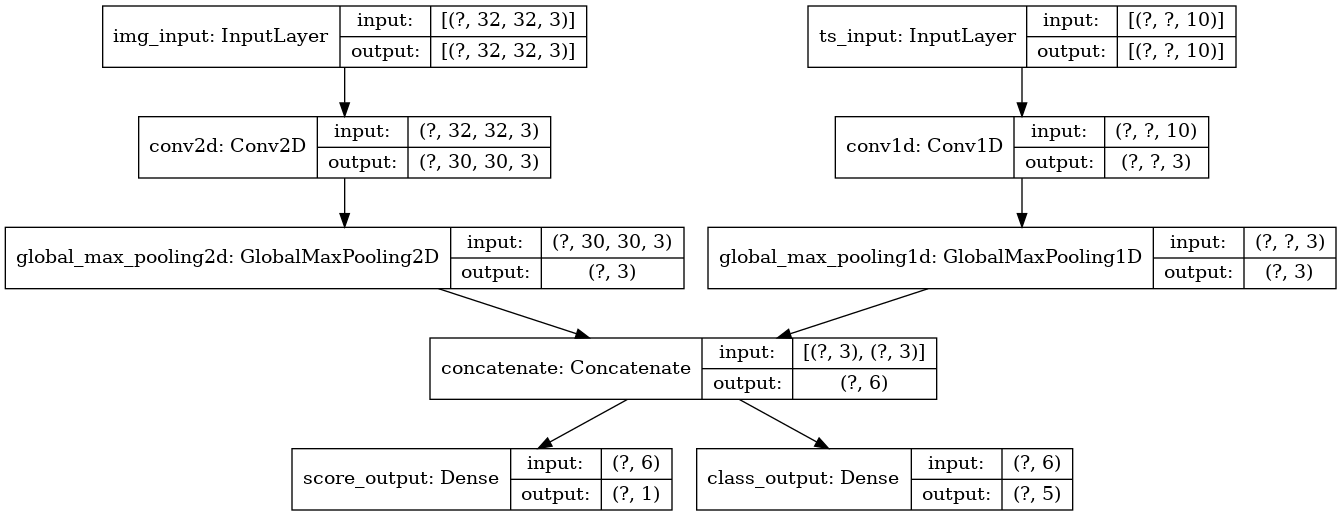

In [29]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

在编译时，通过将损失函数作为列表传递，我们可以为不同的输出指定不同的损失：

In [30]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

如果我们仅将单个损失函数传递给模型，则相同的损失函数将应用于每个输出（此处不合适）。

对于指标同样如此：

In [31]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
    metrics=[
        [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        [keras.metrics.CategoricalAccuracy()],
    ],
)

由于我们已为输出层命名，我们还可以通过字典指定每个输出的损失和指标：

In [32]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
)

如果您的输出超过 2 个，我们建议使用显式名称和字典。

可以使用 `loss_weights` 参数为特定于输出的不同损失赋予不同的权重（例如，在我们的示例中，我们可能希望通过为类损失赋予 2 倍重要性来向“得分”损失赋予特权）：

In [33]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={
        "score_output": keras.losses.MeanSquaredError(),
        "class_output": keras.losses.CategoricalCrossentropy(),
    },
    metrics={
        "score_output": [
            keras.metrics.MeanAbsolutePercentageError(),
            keras.metrics.MeanAbsoluteError(),
        ],
        "class_output": [keras.metrics.CategoricalAccuracy()],
    },
    loss_weights={"score_output": 2.0, "class_output": 1.0},
)

您还可以选择不为某些输出计算损失，前提是这些输出仅用于预测而不是训练：

In [34]:
# List loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[None, keras.losses.CategoricalCrossentropy()],
)

# Or dict loss version
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss={"class_output": keras.losses.CategoricalCrossentropy()},
)

在 fit 中将数据传递给多输入或多输出模型的方式与在编译中指定损失函数的方式类似：您可以传递 **NumPy 数组的列表**（以 1:1 映射到接收损失函数的输出）或**将输出名称映射到 NumPy 数组的字典**。

In [35]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=[keras.losses.MeanSquaredError(), keras.losses.CategoricalCrossentropy()],
)

# Generate dummy NumPy data
img_data = np.random.random_sample(size=(100, 32, 32, 3))
ts_data = np.random.random_sample(size=(100, 20, 10))
score_targets = np.random.random_sample(size=(100, 1))
class_targets = np.random.random_sample(size=(100, 5))

# Fit on lists
model.fit([img_data, ts_data], [score_targets, class_targets], batch_size=32, epochs=1)

# Alternatively, fit on dicts
model.fit(
    {"img_input": img_data, "ts_input": ts_data},
    {"score_output": score_targets, "class_output": class_targets},
    batch_size=32,
    epochs=1,
)

1/4 [======>.......................] - ETA: 0s - loss: 7.1163 - score_output_loss: 2.4520 - class_output_loss: 4.6643

4/4 [==============================] - 0s 6ms/step - loss: 6.8328 - score_output_loss: 2.0614 - class_output_loss: 4.7713


1/4 [======>.......................] - ETA: 0s - loss: 6.3610 - score_output_loss: 1.6283 - class_output_loss: 4.7327

4/4 [==============================] - 0s 4ms/step - loss: 6.0407 - score_output_loss: 1.3442 - class_output_loss: 4.6965


下面是 `Dataset` 的用例：与我们对 NumPy 数组执行的操作类似，`Dataset` 应返回一个字典元组。

In [36]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (
        {"img_input": img_data, "ts_input": ts_data},
        {"score_output": score_targets, "class_output": class_targets},
    )
)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(64)

model.fit(train_dataset, epochs=1)

1/2 [==============>...............] - ETA: 0s - loss: 5.7020 - score_output_loss: 1.0572 - class_output_loss: 4.6448

2/2 [==============================] - 0s 9ms/step - loss: 5.6733 - score_output_loss: 1.0224 - class_output_loss: 4.6509


## 使用回调

Keras 中的回调是训练期间（某个周期开始时、某个批次结束时、某个周期结束时等）在不同时间点调用的对象，这些对象可用于实现以下行为：

- 在训练期间的不同时间点进行验证（除了内置的按周期验证外）
- 定期或在超过一定准确率阈值时为模型设置检查点
- 当训练似乎停滞不前时，更改模型的学习率
- 当训练似乎停滞不前时，对顶层进行微调
- 在训练结束或超出特定性能阈值时发送电子邮件或即时消息通知
- 等等

回调可以作为列表传递给您对 `fit()` 的调用：

In [37]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.EarlyStopping(
        # Stop training when `val_loss` is no longer improving
        monitor="val_loss",
        # "no longer improving" being defined as "no better than 1e-2 less"
        min_delta=1e-2,
        # "no longer improving" being further defined as "for at least 2 epochs"
        patience=2,
        verbose=1,
    )
]
model.fit(
    x_train,
    y_train,
    epochs=20,
    batch_size=64,
    callbacks=callbacks,
    validation_split=0.2,
)

Epoch 1/20


  1/625 [..............................] - ETA: 0s - loss: 2.2871 - sparse_categorical_accuracy: 0.0938

 27/625 [>.............................] - ETA: 1s - loss: 1.3840 - sparse_categorical_accuracy: 0.6505

 54/625 [=>............................] - ETA: 1s - loss: 1.0585 - sparse_categorical_accuracy: 0.7251

 81/625 [==>...........................] - ETA: 1s - loss: 0.8808 - sparse_categorical_accuracy: 0.7683

109/625 [====>.........................] - ETA: 0s - loss: 0.7781 - sparse_categorical_accuracy: 0.7942

136/625 [=====>........................] - ETA: 0s - loss: 0.7124 - sparse_categorical_accuracy: 0.8087

163/625 [======>.......................] - ETA: 0s - loss: 0.6537 - sparse_categorical_accuracy: 0.8231

191/625 [========>.....................] - ETA: 0s - loss: 0.6156 - sparse_categorical_accuracy: 0.8330

218/625 [=========>....................] - ETA: 0s - loss: 0.5817 - sparse_categorical_accuracy: 0.8405

246/625 [==========>...................] - ETA: 0s - loss: 0.5532 - sparse_categorical_accuracy: 0.8476

274/625 [============>.................] - ETA: 0s - loss: 0.5318 - sparse_categorical_accuracy: 0.8528

301/625 [=============>................] - ETA: 0s - loss: 0.5090 - sparse_categorical_accuracy: 0.8591

329/625 [==============>...............] - ETA: 0s - loss: 0.4875 - sparse_categorical_accuracy: 0.8650

357/625 [================>.............] - ETA: 0s - loss: 0.4705 - sparse_categorical_accuracy: 0.8691

384/625 [=================>............] - ETA: 0s - loss: 0.4578 - sparse_categorical_accuracy: 0.8724

411/625 [==================>...........] - ETA: 0s - loss: 0.4461 - sparse_categorical_accuracy: 0.8758

439/625 [====================>.........] - ETA: 0s - loss: 0.4327 - sparse_categorical_accuracy: 0.8793

466/625 [=====================>........] - ETA: 0s - loss: 0.4210 - sparse_categorical_accuracy: 0.8827

494/625 [======================>.......] - ETA: 0s - loss: 0.4092 - sparse_categorical_accuracy: 0.8859

521/625 [========================>.....] - ETA: 0s - loss: 0.4013 - sparse_categorical_accuracy: 0.8877

549/625 [=========================>....] - ETA: 0s - loss: 0.3923 - sparse_categorical_accuracy: 0.8899

576/625 [==========================>...] - ETA: 0s - loss: 0.3837 - sparse_categorical_accuracy: 0.8922

603/625 [===========================>..] - ETA: 0s - loss: 0.3759 - sparse_categorical_accuracy: 0.8945

625/625 [==============================] - 2s 2ms/step - loss: 0.3706 - sparse_categorical_accuracy: 0.8957 - val_loss: 0.2357 - val_sparse_categorical_accuracy: 0.9295


Epoch 2/20
  1/625 [..............................] - ETA: 0s - loss: 0.1949 - sparse_categorical_accuracy: 0.9531

 28/625 [>.............................] - ETA: 1s - loss: 0.2018 - sparse_categorical_accuracy: 0.9392

 56/625 [=>............................] - ETA: 1s - loss: 0.2016 - sparse_categorical_accuracy: 0.9408

 83/625 [==>...........................] - ETA: 0s - loss: 0.1958 - sparse_categorical_accuracy: 0.9422

110/625 [====>.........................] - ETA: 0s - loss: 0.1979 - sparse_categorical_accuracy: 0.9423

138/625 [=====>........................] - ETA: 0s - loss: 0.1890 - sparse_categorical_accuracy: 0.9446

165/625 [======>.......................] - ETA: 0s - loss: 0.1912 - sparse_categorical_accuracy: 0.9444

193/625 [========>.....................] - ETA: 0s - loss: 0.1869 - sparse_categorical_accuracy: 0.9454

220/625 [=========>....................] - ETA: 0s - loss: 0.1862 - sparse_categorical_accuracy: 0.9452

247/625 [==========>...................] - ETA: 0s - loss: 0.1870 - sparse_categorical_accuracy: 0.9460

275/625 [============>.................] - ETA: 0s - loss: 0.1875 - sparse_categorical_accuracy: 0.9452

302/625 [=============>................] - ETA: 0s - loss: 0.1859 - sparse_categorical_accuracy: 0.9457

330/625 [==============>...............] - ETA: 0s - loss: 0.1835 - sparse_categorical_accuracy: 0.9459

358/625 [================>.............] - ETA: 0s - loss: 0.1808 - sparse_categorical_accuracy: 0.9468

386/625 [=================>............] - ETA: 0s - loss: 0.1799 - sparse_categorical_accuracy: 0.9470

413/625 [==================>...........] - ETA: 0s - loss: 0.1786 - sparse_categorical_accuracy: 0.9474

440/625 [====================>.........] - ETA: 0s - loss: 0.1790 - sparse_categorical_accuracy: 0.9471

467/625 [=====================>........] - ETA: 0s - loss: 0.1773 - sparse_categorical_accuracy: 0.9478

494/625 [======================>.......] - ETA: 0s - loss: 0.1762 - sparse_categorical_accuracy: 0.9481

521/625 [========================>.....] - ETA: 0s - loss: 0.1751 - sparse_categorical_accuracy: 0.9484

549/625 [=========================>....] - ETA: 0s - loss: 0.1749 - sparse_categorical_accuracy: 0.9485

577/625 [==========================>...] - ETA: 0s - loss: 0.1730 - sparse_categorical_accuracy: 0.9491

604/625 [===========================>..] - ETA: 0s - loss: 0.1727 - sparse_categorical_accuracy: 0.9492

625/625 [==============================] - 1s 2ms/step - loss: 0.1711 - sparse_categorical_accuracy: 0.9495 - val_loss: 0.1696 - val_sparse_categorical_accuracy: 0.9487


Epoch 3/20
  1/625 [..............................] - ETA: 0s - loss: 0.1238 - sparse_categorical_accuracy: 0.9531

 28/625 [>.............................] - ETA: 1s - loss: 0.1143 - sparse_categorical_accuracy: 0.9654

 55/625 [=>............................] - ETA: 1s - loss: 0.1201 - sparse_categorical_accuracy: 0.9659

 82/625 [==>...........................] - ETA: 1s - loss: 0.1125 - sparse_categorical_accuracy: 0.9668

110/625 [====>.........................] - ETA: 0s - loss: 0.1122 - sparse_categorical_accuracy: 0.9668

137/625 [=====>........................] - ETA: 0s - loss: 0.1172 - sparse_categorical_accuracy: 0.9644

164/625 [======>.......................] - ETA: 0s - loss: 0.1185 - sparse_categorical_accuracy: 0.9650

191/625 [========>.....................] - ETA: 0s - loss: 0.1204 - sparse_categorical_accuracy: 0.9643

218/625 [=========>....................] - ETA: 0s - loss: 0.1221 - sparse_categorical_accuracy: 0.9637

245/625 [==========>...................] - ETA: 0s - loss: 0.1191 - sparse_categorical_accuracy: 0.9647

272/625 [============>.................] - ETA: 0s - loss: 0.1220 - sparse_categorical_accuracy: 0.9634

300/625 [=============>................] - ETA: 0s - loss: 0.1203 - sparse_categorical_accuracy: 0.9639

327/625 [==============>...............] - ETA: 0s - loss: 0.1205 - sparse_categorical_accuracy: 0.9636

355/625 [================>.............] - ETA: 0s - loss: 0.1222 - sparse_categorical_accuracy: 0.9633

382/625 [=================>............] - ETA: 0s - loss: 0.1235 - sparse_categorical_accuracy: 0.9633

406/625 [==================>...........] - ETA: 0s - loss: 0.1241 - sparse_categorical_accuracy: 0.9632

433/625 [===================>..........] - ETA: 0s - loss: 0.1231 - sparse_categorical_accuracy: 0.9631

461/625 [=====================>........] - ETA: 0s - loss: 0.1230 - sparse_categorical_accuracy: 0.9633

488/625 [======================>.......] - ETA: 0s - loss: 0.1234 - sparse_categorical_accuracy: 0.9633

515/625 [=======================>......] - ETA: 0s - loss: 0.1242 - sparse_categorical_accuracy: 0.9631

542/625 [=========================>....] - ETA: 0s - loss: 0.1235 - sparse_categorical_accuracy: 0.9634

570/625 [==========================>...] - ETA: 0s - loss: 0.1228 - sparse_categorical_accuracy: 0.9636

597/625 [===========================>..] - ETA: 0s - loss: 0.1220 - sparse_categorical_accuracy: 0.9637

624/625 [============================>.] - ETA: 0s - loss: 0.1225 - sparse_categorical_accuracy: 0.9637

625/625 [==============================] - 1s 2ms/step - loss: 0.1227 - sparse_categorical_accuracy: 0.9637 - val_loss: 0.1703 - val_sparse_categorical_accuracy: 0.9491


Epoch 4/20
  1/625 [..............................] - ETA: 0s - loss: 0.0555 - sparse_categorical_accuracy: 1.0000

 28/625 [>.............................] - ETA: 1s - loss: 0.1138 - sparse_categorical_accuracy: 0.9688

 56/625 [=>............................] - ETA: 1s - loss: 0.1077 - sparse_categorical_accuracy: 0.9690

 83/625 [==>...........................] - ETA: 0s - loss: 0.1044 - sparse_categorical_accuracy: 0.9701

110/625 [====>.........................] - ETA: 0s - loss: 0.1070 - sparse_categorical_accuracy: 0.9697

137/625 [=====>........................] - ETA: 0s - loss: 0.1056 - sparse_categorical_accuracy: 0.9692

164/625 [======>.......................] - ETA: 0s - loss: 0.1046 - sparse_categorical_accuracy: 0.9696

191/625 [========>.....................] - ETA: 0s - loss: 0.1018 - sparse_categorical_accuracy: 0.9702

218/625 [=========>....................] - ETA: 0s - loss: 0.1019 - sparse_categorical_accuracy: 0.9702

245/625 [==========>...................] - ETA: 0s - loss: 0.1018 - sparse_categorical_accuracy: 0.9702

273/625 [============>.................] - ETA: 0s - loss: 0.1002 - sparse_categorical_accuracy: 0.9708

301/625 [=============>................] - ETA: 0s - loss: 0.0993 - sparse_categorical_accuracy: 0.9710

328/625 [==============>...............] - ETA: 0s - loss: 0.0984 - sparse_categorical_accuracy: 0.9708

356/625 [================>.............] - ETA: 0s - loss: 0.0981 - sparse_categorical_accuracy: 0.9710

382/625 [=================>............] - ETA: 0s - loss: 0.0987 - sparse_categorical_accuracy: 0.9704

410/625 [==================>...........] - ETA: 0s - loss: 0.0996 - sparse_categorical_accuracy: 0.9701

437/625 [===================>..........] - ETA: 0s - loss: 0.0993 - sparse_categorical_accuracy: 0.9705

464/625 [=====================>........] - ETA: 0s - loss: 0.0985 - sparse_categorical_accuracy: 0.9707

491/625 [======================>.......] - ETA: 0s - loss: 0.0980 - sparse_categorical_accuracy: 0.9709

518/625 [=======================>......] - ETA: 0s - loss: 0.0981 - sparse_categorical_accuracy: 0.9707

546/625 [=========================>....] - ETA: 0s - loss: 0.0971 - sparse_categorical_accuracy: 0.9709

573/625 [==========================>...] - ETA: 0s - loss: 0.0974 - sparse_categorical_accuracy: 0.9709

601/625 [===========================>..] - ETA: 0s - loss: 0.0972 - sparse_categorical_accuracy: 0.9709

625/625 [==============================] - 1s 2ms/step - loss: 0.0967 - sparse_categorical_accuracy: 0.9712 - val_loss: 0.1451 - val_sparse_categorical_accuracy: 0.9598


Epoch 5/20
  1/625 [..............................] - ETA: 0s - loss: 0.1334 - sparse_categorical_accuracy: 0.9531

 28/625 [>.............................] - ETA: 1s - loss: 0.0757 - sparse_categorical_accuracy: 0.9749

 55/625 [=>............................] - ETA: 1s - loss: 0.0792 - sparse_categorical_accuracy: 0.9741

 82/625 [==>...........................] - ETA: 1s - loss: 0.0770 - sparse_categorical_accuracy: 0.9754

109/625 [====>.........................] - ETA: 0s - loss: 0.0776 - sparse_categorical_accuracy: 0.9755

136/625 [=====>........................] - ETA: 0s - loss: 0.0766 - sparse_categorical_accuracy: 0.9756

164/625 [======>.......................] - ETA: 0s - loss: 0.0759 - sparse_categorical_accuracy: 0.9764

191/625 [========>.....................] - ETA: 0s - loss: 0.0735 - sparse_categorical_accuracy: 0.9771

219/625 [=========>....................] - ETA: 0s - loss: 0.0727 - sparse_categorical_accuracy: 0.9772

246/625 [==========>...................] - ETA: 0s - loss: 0.0769 - sparse_categorical_accuracy: 0.9767

273/625 [============>.................] - ETA: 0s - loss: 0.0788 - sparse_categorical_accuracy: 0.9758

300/625 [=============>................] - ETA: 0s - loss: 0.0795 - sparse_categorical_accuracy: 0.9760

327/625 [==============>...............] - ETA: 0s - loss: 0.0806 - sparse_categorical_accuracy: 0.9758

354/625 [===============>..............] - ETA: 0s - loss: 0.0804 - sparse_categorical_accuracy: 0.9758

381/625 [=================>............] - ETA: 0s - loss: 0.0801 - sparse_categorical_accuracy: 0.9757

408/625 [==================>...........] - ETA: 0s - loss: 0.0808 - sparse_categorical_accuracy: 0.9755

435/625 [===================>..........] - ETA: 0s - loss: 0.0801 - sparse_categorical_accuracy: 0.9760

462/625 [=====================>........] - ETA: 0s - loss: 0.0793 - sparse_categorical_accuracy: 0.9763

489/625 [======================>.......] - ETA: 0s - loss: 0.0799 - sparse_categorical_accuracy: 0.9761

516/625 [=======================>......] - ETA: 0s - loss: 0.0794 - sparse_categorical_accuracy: 0.9762

543/625 [=========================>....] - ETA: 0s - loss: 0.0792 - sparse_categorical_accuracy: 0.9763

570/625 [==========================>...] - ETA: 0s - loss: 0.0792 - sparse_categorical_accuracy: 0.9762

597/625 [===========================>..] - ETA: 0s - loss: 0.0785 - sparse_categorical_accuracy: 0.9765

624/625 [============================>.] - ETA: 0s - loss: 0.0794 - sparse_categorical_accuracy: 0.9764

625/625 [==============================] - 1s 2ms/step - loss: 0.0795 - sparse_categorical_accuracy: 0.9764 - val_loss: 0.1361 - val_sparse_categorical_accuracy: 0.9610


Epoch 6/20
  1/625 [..............................] - ETA: 0s - loss: 0.0183 - sparse_categorical_accuracy: 1.0000

 28/625 [>.............................] - ETA: 1s - loss: 0.0685 - sparse_categorical_accuracy: 0.9827

 55/625 [=>............................] - ETA: 1s - loss: 0.0567 - sparse_categorical_accuracy: 0.9832

 82/625 [==>...........................] - ETA: 1s - loss: 0.0540 - sparse_categorical_accuracy: 0.9844

109/625 [====>.........................] - ETA: 0s - loss: 0.0559 - sparse_categorical_accuracy: 0.9847

136/625 [=====>........................] - ETA: 0s - loss: 0.0565 - sparse_categorical_accuracy: 0.9836

163/625 [======>.......................] - ETA: 0s - loss: 0.0572 - sparse_categorical_accuracy: 0.9832

190/625 [========>.....................] - ETA: 0s - loss: 0.0605 - sparse_categorical_accuracy: 0.9820

217/625 [=========>....................] - ETA: 0s - loss: 0.0596 - sparse_categorical_accuracy: 0.9819

244/625 [==========>...................] - ETA: 0s - loss: 0.0600 - sparse_categorical_accuracy: 0.9819

272/625 [============>.................] - ETA: 0s - loss: 0.0600 - sparse_categorical_accuracy: 0.9819

299/625 [=============>................] - ETA: 0s - loss: 0.0597 - sparse_categorical_accuracy: 0.9820

326/625 [==============>...............] - ETA: 0s - loss: 0.0613 - sparse_categorical_accuracy: 0.9813

353/625 [===============>..............] - ETA: 0s - loss: 0.0618 - sparse_categorical_accuracy: 0.9810

381/625 [=================>............] - ETA: 0s - loss: 0.0631 - sparse_categorical_accuracy: 0.9805

408/625 [==================>...........] - ETA: 0s - loss: 0.0637 - sparse_categorical_accuracy: 0.9805

435/625 [===================>..........] - ETA: 0s - loss: 0.0653 - sparse_categorical_accuracy: 0.9802

462/625 [=====================>........] - ETA: 0s - loss: 0.0655 - sparse_categorical_accuracy: 0.9801

489/625 [======================>.......] - ETA: 0s - loss: 0.0654 - sparse_categorical_accuracy: 0.9803

516/625 [=======================>......] - ETA: 0s - loss: 0.0663 - sparse_categorical_accuracy: 0.9800

543/625 [=========================>....] - ETA: 0s - loss: 0.0656 - sparse_categorical_accuracy: 0.9800

570/625 [==========================>...] - ETA: 0s - loss: 0.0659 - sparse_categorical_accuracy: 0.9799

597/625 [===========================>..] - ETA: 0s - loss: 0.0667 - sparse_categorical_accuracy: 0.9798

624/625 [============================>.] - ETA: 0s - loss: 0.0665 - sparse_categorical_accuracy: 0.9800

625/625 [==============================] - 1s 2ms/step - loss: 0.0665 - sparse_categorical_accuracy: 0.9801 - val_loss: 0.1460 - val_sparse_categorical_accuracy: 0.9583


Epoch 00006: early stopping


### 提供多个内置回调

- `ModelCheckpoint`：定期保存模型。
- `EarlyStopping`：当训练不再改善验证指标时，停止训练。
-  `TensorBoard`：定期编写可在 [TensorBoard](https://tensorflow.google.cn/tensorboard) 中可视化的模型日志（更多详细信息，请参阅“可视化”部分）。
- `CSVLogger`：将损失和指标数据流式传输到 CSV 文件。
- 等等

有关完整列表，请参阅[回调文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/)。

### 编写您自己的回调

您可以通过扩展基类 `keras.callbacks.Callback` 来创建自定义回调。回调可以通过类属性 `self.model` 访问其关联的模型。

确保阅读[编写自定义回调的完整指南](https://tensorflow.google.cn/guide/keras/custom_callback/)。

下面是一个简单的示例，在训练期间保存每个批次的损失值列表：

In [38]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))


## 为模型设置检查点

根据相对较大的数据集训练模型时，经常保存模型的检查点至关重要。

实现此目标的最简单方法是使用 `ModelCheckpoint` 回调：

In [39]:
model = get_compiled_model()

callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath="mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]
model.fit(
    x_train, y_train, epochs=2, batch_size=64, callbacks=callbacks, validation_split=0.2
)

Epoch 1/2


  1/625 [..............................] - ETA: 0s - loss: 2.3601 - sparse_categorical_accuracy: 0.0469

 27/625 [>.............................] - ETA: 1s - loss: 1.5015 - sparse_categorical_accuracy: 0.5781

 53/625 [=>............................] - ETA: 1s - loss: 1.1342 - sparse_categorical_accuracy: 0.6854

 80/625 [==>...........................] - ETA: 1s - loss: 0.9366 - sparse_categorical_accuracy: 0.7418

106/625 [====>.........................] - ETA: 0s - loss: 0.8117 - sparse_categorical_accuracy: 0.7742

133/625 [=====>........................] - ETA: 0s - loss: 0.7305 - sparse_categorical_accuracy: 0.7973

160/625 [======>.......................] - ETA: 0s - loss: 0.6733 - sparse_categorical_accuracy: 0.8123

186/625 [=======>......................] - ETA: 0s - loss: 0.6320 - sparse_categorical_accuracy: 0.8235

213/625 [=========>....................] - ETA: 0s - loss: 0.5919 - sparse_categorical_accuracy: 0.8345

240/625 [==========>...................] - ETA: 0s - loss: 0.5643 - sparse_categorical_accuracy: 0.8412

267/625 [===========>..................] - ETA: 0s - loss: 0.5347 - sparse_categorical_accuracy: 0.8497

294/625 [=============>................] - ETA: 0s - loss: 0.5108 - sparse_categorical_accuracy: 0.8559

321/625 [==============>...............] - ETA: 0s - loss: 0.4935 - sparse_categorical_accuracy: 0.8607

348/625 [===============>..............] - ETA: 0s - loss: 0.4799 - sparse_categorical_accuracy: 0.8644

376/625 [=================>............] - ETA: 0s - loss: 0.4650 - sparse_categorical_accuracy: 0.8685

403/625 [==================>...........] - ETA: 0s - loss: 0.4532 - sparse_categorical_accuracy: 0.8721

429/625 [===================>..........] - ETA: 0s - loss: 0.4432 - sparse_categorical_accuracy: 0.8750

456/625 [====================>.........] - ETA: 0s - loss: 0.4325 - sparse_categorical_accuracy: 0.8779

483/625 [======================>.......] - ETA: 0s - loss: 0.4228 - sparse_categorical_accuracy: 0.8804

510/625 [=======================>......] - ETA: 0s - loss: 0.4136 - sparse_categorical_accuracy: 0.8828

537/625 [========================>.....] - ETA: 0s - loss: 0.4056 - sparse_categorical_accuracy: 0.8854

565/625 [==========================>...] - ETA: 0s - loss: 0.3989 - sparse_categorical_accuracy: 0.8873

592/625 [===========================>..] - ETA: 0s - loss: 0.3909 - sparse_categorical_accuracy: 0.8895

619/625 [============================>.] - ETA: 0s - loss: 0.3832 - sparse_categorical_accuracy: 0.8913


Epoch 00001: val_loss improved from inf to 0.25572, saving model to mymodel_1
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: mymodel_1/assets


625/625 [==============================] - 2s 3ms/step - loss: 0.3820 - sparse_categorical_accuracy: 0.8916 - val_loss: 0.2557 - val_sparse_categorical_accuracy: 0.9232


Epoch 2/2
  1/625 [..............................] - ETA: 0s - loss: 0.1786 - sparse_categorical_accuracy: 0.9219

 28/625 [>.............................] - ETA: 1s - loss: 0.1867 - sparse_categorical_accuracy: 0.9481

 55/625 [=>............................] - ETA: 1s - loss: 0.1935 - sparse_categorical_accuracy: 0.9457

 82/625 [==>...........................] - ETA: 1s - loss: 0.2070 - sparse_categorical_accuracy: 0.9417

109/625 [====>.........................] - ETA: 0s - loss: 0.2101 - sparse_categorical_accuracy: 0.9407

136/625 [=====>........................] - ETA: 0s - loss: 0.2118 - sparse_categorical_accuracy: 0.9399

163/625 [======>.......................] - ETA: 0s - loss: 0.2101 - sparse_categorical_accuracy: 0.9398

190/625 [========>.....................] - ETA: 0s - loss: 0.2056 - sparse_categorical_accuracy: 0.9414

217/625 [=========>....................] - ETA: 0s - loss: 0.2032 - sparse_categorical_accuracy: 0.9419

245/625 [==========>...................] - ETA: 0s - loss: 0.2018 - sparse_categorical_accuracy: 0.9430

272/625 [============>.................] - ETA: 0s - loss: 0.1993 - sparse_categorical_accuracy: 0.9435

298/625 [=============>................] - ETA: 0s - loss: 0.1969 - sparse_categorical_accuracy: 0.9442

325/625 [==============>...............] - ETA: 0s - loss: 0.1968 - sparse_categorical_accuracy: 0.9439

352/625 [===============>..............] - ETA: 0s - loss: 0.1945 - sparse_categorical_accuracy: 0.9442

379/625 [=================>............] - ETA: 0s - loss: 0.1915 - sparse_categorical_accuracy: 0.9449

406/625 [==================>...........] - ETA: 0s - loss: 0.1923 - sparse_categorical_accuracy: 0.9444

433/625 [===================>..........] - ETA: 0s - loss: 0.1922 - sparse_categorical_accuracy: 0.9444

460/625 [=====================>........] - ETA: 0s - loss: 0.1900 - sparse_categorical_accuracy: 0.9447

487/625 [======================>.......] - ETA: 0s - loss: 0.1876 - sparse_categorical_accuracy: 0.9452

514/625 [=======================>......] - ETA: 0s - loss: 0.1840 - sparse_categorical_accuracy: 0.9464

542/625 [=========================>....] - ETA: 0s - loss: 0.1820 - sparse_categorical_accuracy: 0.9466

569/625 [==========================>...] - ETA: 0s - loss: 0.1809 - sparse_categorical_accuracy: 0.9467

595/625 [===========================>..] - ETA: 0s - loss: 0.1808 - sparse_categorical_accuracy: 0.9467

622/625 [============================>.] - ETA: 0s - loss: 0.1808 - sparse_categorical_accuracy: 0.9466


Epoch 00002: val_loss improved from 0.25572 to 0.17587, saving model to mymodel_2


INFO:tensorflow:Assets written to: mymodel_2/assets


625/625 [==============================] - 2s 3ms/step - loss: 0.1804 - sparse_categorical_accuracy: 0.9467 - val_loss: 0.1759 - val_sparse_categorical_accuracy: 0.9459


`ModelCheckpoint` 回调可用于实现容错：在训练随机中断的情况下，从模型的最后保存状态重新开始训练的能力。下面是一个基本示例：

In [40]:
import os

# Prepare a directory to store all the checkpoints.
checkpoint_dir = "./ckpt"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)


def make_or_restore_model():
    # Either restore the latest model, or create a fresh one
    # if there is no checkpoint available.
    checkpoints = [checkpoint_dir + "/" + name for name in os.listdir(checkpoint_dir)]
    if checkpoints:
        latest_checkpoint = max(checkpoints, key=os.path.getctime)
        print("Restoring from", latest_checkpoint)
        return keras.models.load_model(latest_checkpoint)
    print("Creating a new model")
    return get_compiled_model()


model = make_or_restore_model()
callbacks = [
    # This callback saves a SavedModel every 100 batches.
    # We include the training loss in the saved model name.
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_dir + "/ckpt-loss={loss:.2f}", save_freq=100
    )
]
model.fit(x_train, y_train, epochs=1, callbacks=callbacks)

Creating a new model


   1/1563 [..............................] - ETA: 0s - loss: 2.3932 - sparse_categorical_accuracy: 0.0312

  25/1563 [..............................] - ETA: 3s - loss: 1.7080 - sparse_categorical_accuracy: 0.5487

  49/1563 [..............................] - ETA: 3s - loss: 1.3333 - sparse_categorical_accuracy: 0.6492

  73/1563 [>.............................] - ETA: 3s - loss: 1.0981 - sparse_categorical_accuracy: 0.7106

  97/1563 [>.............................] - ETA: 3s - loss: 0.9454 - sparse_categorical_accuracy: 0.7484

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.93/assets


 100/1563 [>.............................] - ETA: 11s - loss: 0.9340 - sparse_categorical_accuracy: 0.7516

 123/1563 [=>............................] - ETA: 9s - loss: 0.8414 - sparse_categorical_accuracy: 0.7749 

 147/1563 [=>............................] - ETA: 8s - loss: 0.7806 - sparse_categorical_accuracy: 0.7889

 171/1563 [==>...........................] - ETA: 7s - loss: 0.7283 - sparse_categorical_accuracy: 0.8014

 195/1563 [==>...........................] - ETA: 6s - loss: 0.6884 - sparse_categorical_accuracy: 0.8109

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.68/assets


 200/1563 [==>...........................] - ETA: 9s - loss: 0.6793 - sparse_categorical_accuracy: 0.8128

 223/1563 [===>..........................] - ETA: 8s - loss: 0.6444 - sparse_categorical_accuracy: 0.8213

 247/1563 [===>..........................] - ETA: 8s - loss: 0.6097 - sparse_categorical_accuracy: 0.8305

 271/1563 [====>.........................] - ETA: 7s - loss: 0.5884 - sparse_categorical_accuracy: 0.8358

 295/1563 [====>.........................] - ETA: 6s - loss: 0.5696 - sparse_categorical_accuracy: 0.8404

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.57/assets


 300/1563 [====>.........................] - ETA: 8s - loss: 0.5691 - sparse_categorical_accuracy: 0.8404

 322/1563 [=====>........................] - ETA: 8s - loss: 0.5516 - sparse_categorical_accuracy: 0.8441

 346/1563 [=====>........................] - ETA: 7s - loss: 0.5349 - sparse_categorical_accuracy: 0.8487

 370/1563 [======>.......................] - ETA: 7s - loss: 0.5192 - sparse_categorical_accuracy: 0.8524

 394/1563 [======>.......................] - ETA: 6s - loss: 0.5054 - sparse_categorical_accuracy: 0.8571

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.50/assets


 400/1563 [======>.......................] - ETA: 7s - loss: 0.5048 - sparse_categorical_accuracy: 0.8574

 423/1563 [=======>......................] - ETA: 7s - loss: 0.4977 - sparse_categorical_accuracy: 0.8596

 448/1563 [=======>......................] - ETA: 6s - loss: 0.4866 - sparse_categorical_accuracy: 0.8628

 472/1563 [========>.....................] - ETA: 6s - loss: 0.4749 - sparse_categorical_accuracy: 0.8663

 496/1563 [========>.....................] - ETA: 6s - loss: 0.4680 - sparse_categorical_accuracy: 0.8679

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.47/assets


 500/1563 [========>.....................] - ETA: 6s - loss: 0.4667 - sparse_categorical_accuracy: 0.8682

 522/1563 [=========>....................] - ETA: 6s - loss: 0.4580 - sparse_categorical_accuracy: 0.8704

 545/1563 [=========>....................] - ETA: 6s - loss: 0.4506 - sparse_categorical_accuracy: 0.8721

 569/1563 [=========>....................] - ETA: 6s - loss: 0.4431 - sparse_categorical_accuracy: 0.8743

 593/1563 [==========>...................] - ETA: 5s - loss: 0.4350 - sparse_categorical_accuracy: 0.8764

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.43/assets


 600/1563 [==========>...................] - ETA: 6s - loss: 0.4328 - sparse_categorical_accuracy: 0.8769

 623/1563 [==========>...................] - ETA: 6s - loss: 0.4267 - sparse_categorical_accuracy: 0.8787

 647/1563 [===========>..................] - ETA: 5s - loss: 0.4207 - sparse_categorical_accuracy: 0.8804

 671/1563 [===========>..................] - ETA: 5s - loss: 0.4134 - sparse_categorical_accuracy: 0.8824

 695/1563 [============>.................] - ETA: 5s - loss: 0.4072 - sparse_categorical_accuracy: 0.8841

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.41/assets


 700/1563 [============>.................] - ETA: 5s - loss: 0.4057 - sparse_categorical_accuracy: 0.8845

 723/1563 [============>.................] - ETA: 5s - loss: 0.4023 - sparse_categorical_accuracy: 0.8854

 747/1563 [=============>................] - ETA: 5s - loss: 0.3985 - sparse_categorical_accuracy: 0.8867

 771/1563 [=============>................] - ETA: 4s - loss: 0.3936 - sparse_categorical_accuracy: 0.8878

 795/1563 [==============>...............] - ETA: 4s - loss: 0.3884 - sparse_categorical_accuracy: 0.8893

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.39/assets


 800/1563 [==============>...............] - ETA: 4s - loss: 0.3874 - sparse_categorical_accuracy: 0.8896

 823/1563 [==============>...............] - ETA: 4s - loss: 0.3842 - sparse_categorical_accuracy: 0.8903

 847/1563 [===============>..............] - ETA: 4s - loss: 0.3793 - sparse_categorical_accuracy: 0.8918

 871/1563 [===============>..............] - ETA: 4s - loss: 0.3742 - sparse_categorical_accuracy: 0.8931

 895/1563 [================>.............] - ETA: 4s - loss: 0.3691 - sparse_categorical_accuracy: 0.8947

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.37/assets


 900/1563 [================>.............] - ETA: 4s - loss: 0.3685 - sparse_categorical_accuracy: 0.8948

 923/1563 [================>.............] - ETA: 4s - loss: 0.3649 - sparse_categorical_accuracy: 0.8959

 947/1563 [=================>............] - ETA: 3s - loss: 0.3615 - sparse_categorical_accuracy: 0.8968

 971/1563 [=================>............] - ETA: 3s - loss: 0.3574 - sparse_categorical_accuracy: 0.8979

 995/1563 [==================>...........] - ETA: 3s - loss: 0.3541 - sparse_categorical_accuracy: 0.8987

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.35/assets


1000/1563 [==================>...........] - ETA: 3s - loss: 0.3542 - sparse_categorical_accuracy: 0.8987

1023/1563 [==================>...........] - ETA: 3s - loss: 0.3515 - sparse_categorical_accuracy: 0.8995

1047/1563 [===================>..........] - ETA: 3s - loss: 0.3477 - sparse_categorical_accuracy: 0.9004

1070/1563 [===================>..........] - ETA: 3s - loss: 0.3439 - sparse_categorical_accuracy: 0.9015

1094/1563 [===================>..........] - ETA: 2s - loss: 0.3407 - sparse_categorical_accuracy: 0.9020

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.34/assets


1100/1563 [====================>.........] - ETA: 2s - loss: 0.3396 - sparse_categorical_accuracy: 0.9023

1123/1563 [====================>.........] - ETA: 2s - loss: 0.3375 - sparse_categorical_accuracy: 0.9029

1147/1563 [=====================>........] - ETA: 2s - loss: 0.3341 - sparse_categorical_accuracy: 0.9039

1171/1563 [=====================>........] - ETA: 2s - loss: 0.3305 - sparse_categorical_accuracy: 0.9049

1195/1563 [=====================>........] - ETA: 2s - loss: 0.3280 - sparse_categorical_accuracy: 0.9056

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.33/assets


1200/1563 [======================>.......] - ETA: 2s - loss: 0.3271 - sparse_categorical_accuracy: 0.9059

1223/1563 [======================>.......] - ETA: 2s - loss: 0.3246 - sparse_categorical_accuracy: 0.9066

1247/1563 [======================>.......] - ETA: 2s - loss: 0.3228 - sparse_categorical_accuracy: 0.9072

1271/1563 [=======================>......] - ETA: 1s - loss: 0.3206 - sparse_categorical_accuracy: 0.9077

1295/1563 [=======================>......] - ETA: 1s - loss: 0.3182 - sparse_categorical_accuracy: 0.9084

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.32/assets


1300/1563 [=======================>......] - ETA: 1s - loss: 0.3175 - sparse_categorical_accuracy: 0.9086

1324/1563 [========================>.....] - ETA: 1s - loss: 0.3155 - sparse_categorical_accuracy: 0.9091

1348/1563 [========================>.....] - ETA: 1s - loss: 0.3136 - sparse_categorical_accuracy: 0.9095

1372/1563 [=========================>....] - ETA: 1s - loss: 0.3110 - sparse_categorical_accuracy: 0.9101

1396/1563 [=========================>....] - ETA: 1s - loss: 0.3089 - sparse_categorical_accuracy: 0.9107

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.31/assets


1400/1563 [=========================>....] - ETA: 1s - loss: 0.3086 - sparse_categorical_accuracy: 0.9108

1422/1563 [==========================>...] - ETA: 0s - loss: 0.3069 - sparse_categorical_accuracy: 0.9112

1446/1563 [==========================>...] - ETA: 0s - loss: 0.3050 - sparse_categorical_accuracy: 0.9117

1470/1563 [===========================>..] - ETA: 0s - loss: 0.3026 - sparse_categorical_accuracy: 0.9124

1494/1563 [===========================>..] - ETA: 0s - loss: 0.3006 - sparse_categorical_accuracy: 0.9130

INFO:tensorflow:Assets written to: ./ckpt/ckpt-loss=0.30/assets


1500/1563 [===========================>..] - ETA: 0s - loss: 0.3001 - sparse_categorical_accuracy: 0.9131

1523/1563 [============================>.] - ETA: 0s - loss: 0.2980 - sparse_categorical_accuracy: 0.9137

1547/1563 [============================>.] - ETA: 0s - loss: 0.2960 - sparse_categorical_accuracy: 0.9143

1563/1563 [==============================] - 10s 6ms/step - loss: 0.2950 - sparse_categorical_accuracy: 0.9146


您还可以编写自己的回调来保存和恢复模型。

有关序列化和保存的完整指南，请参阅[保存和序列化模型](https://tensorflow.google.cn/guide/keras/save_and_serialize/)指南。

## 使用学习率时间表

训练深度学习模型的常见模式是随着训练的进行逐渐减少学习。这通常称为“学习率衰减”。

学习衰减时间表可以是静态的（根据当前周期或当前批次索引提前确定），也可以是动态的（响应模型的当前行为，尤其是验证损失）。

### 将时间表传递给优化器

通过将时间表对象作为优化器中的 `learning_rate` 参数传递，您可以轻松使用静态学习率衰减时间表：

In [41]:
initial_learning_rate = 0.1
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

optimizer = keras.optimizers.RMSprop(learning_rate=lr_schedule)

提供了几个内置时间表：`ExponentialDecay`、`PiecewiseConstantDecay`、`PolynomialDecay` 和 `InverseTimeDecay`。

### 使用回调实现动态学习率时间表

由于优化器无法访问验证指标，因此无法使用这些时间表对象来实现动态学习率时间表（例如，当验证损失不再改善时降低学习率）。

但是，回调确实可以访问所有指标，包括验证指标！因此，您可以通过使用可修改优化器上的当前学习率的回调来实现此模式。实际上，它甚至以 `ReduceLROnPlateau` 回调的形式内置。

## 可视化训练期间的损失和指标

在训练期间密切关注模型的最佳方法是使用 [TensorBoard](https://tensorflow.google.cn/tensorboard)，这是一个基于浏览器的应用，它可以在本地运行，为您提供：

- 训练和评估的实时损失和指标图
- （可选）层激活直方图的可视化
- （可选）`Embedding` 层学习的嵌入空间的 3D 可视化

如果您已通过 pip 安装了 TensorFlow，则应当能够从命令行启动 TensorBoard：

```
tensorboard --logdir=/full_path_to_your_logs
```

### 使用 TensorBoard 回调

将 TensorBoard 与 Keras 模型和 fit 方法一起使用的最简单方式是 `TensorBoard` 回调。

在最简单的情况下，只需指定您希望回调写入日志的位置即可：

In [42]:
keras.callbacks.TensorBoard(
    log_dir="/full_path_to_your_logs",
    histogram_freq=0,  # How often to log histogram visualizations
    embeddings_freq=0,  # How often to log embedding visualizations
    update_freq="epoch",
)  # How often to write logs (default: once per epoch)

有关更多信息，请参阅 [`TensorBoard` 回调的文档](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks/tensorboard/)。